In [2]:
library(SingleCellExperiment)
library(Seurat)
library(mclust)
library(dplyr)

In [6]:
counts_raw <- read.table("/extra/sebastian_arnolds/analysis/trim/counts_matrix.tsv",sep="\t")
barcodes_vector <- as.vector(
    read.table("/extra/sebastian_arnolds/analysis/celseq_barcodes_raw_all.txt")[, 1]
)
count_matrix <- as.matrix(counts_raw[, barcodes_vector])

# Change labels for genes of interest
name_map = list(
    ENSMUSG00000062327 = "Brachyury",
    ENSMUSG00000032446 = "Eomes",
    ENSMUSG00000030544 = "Mesp1",
    ENSMUSG00000024406 = "Pou5f1",
    ENSMUSG00000012396 = "nanog",
    ENSMUSG00000096014 = "Sox1",
    ENSMUSG00000074637 = "Sox2",
    ENSMUSG00000090125 = "Pou3f1",
    ENSMUSG00000060206 = "zfp462",
    ENSMUSG00000031297 = "slc7a3"
)

for (i in 1:length(name_map)){
    old_gene_name <- names(name_map[i])
    new_gene_name <- name_map[[i]]
    #message(old_gene_name, "→", new_gene_name)
    rownames(count_matrix)[which(rownames(count_matrix) == old_gene_name)] <- new_gene_name
}

saveRDS(count_matrix, "seurat_matrix.rds")

In [7]:
#umi <- as.matrix(readRDS("seurat_matrix.rds"))

#summary(rowSums(umi))
#summary(colSums(umi))

seuset <- CreateSeuratObject(
    raw.data = umi,
    min.cells = 2,   # detected
    min.genes = 170
)



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     2.0    15.0   172.8   116.0 51759.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     68    4116   16552   18959   27709   75107 

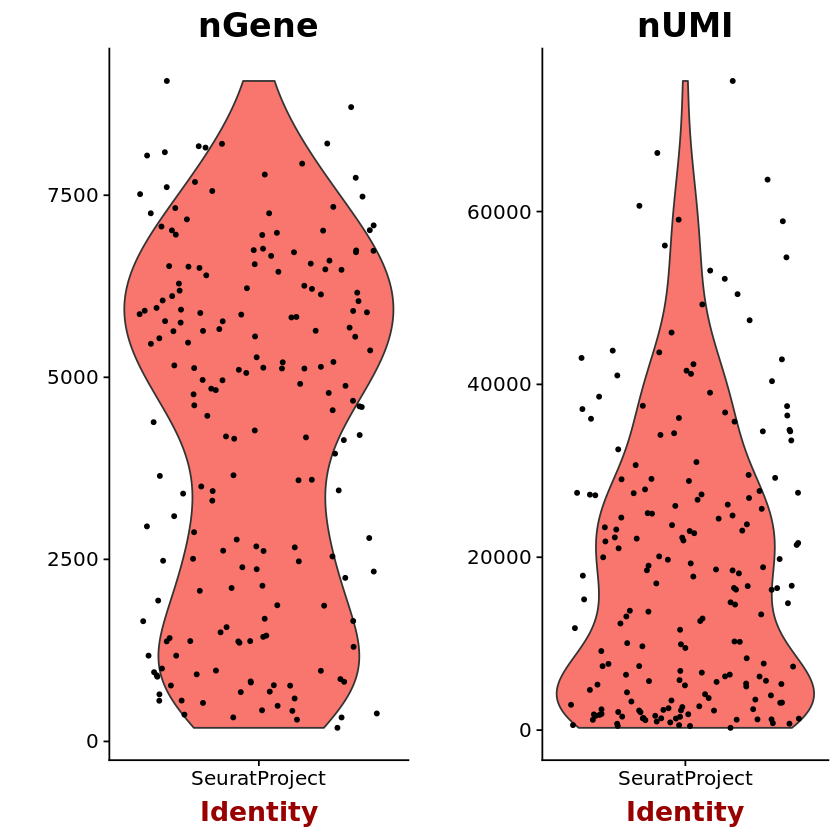

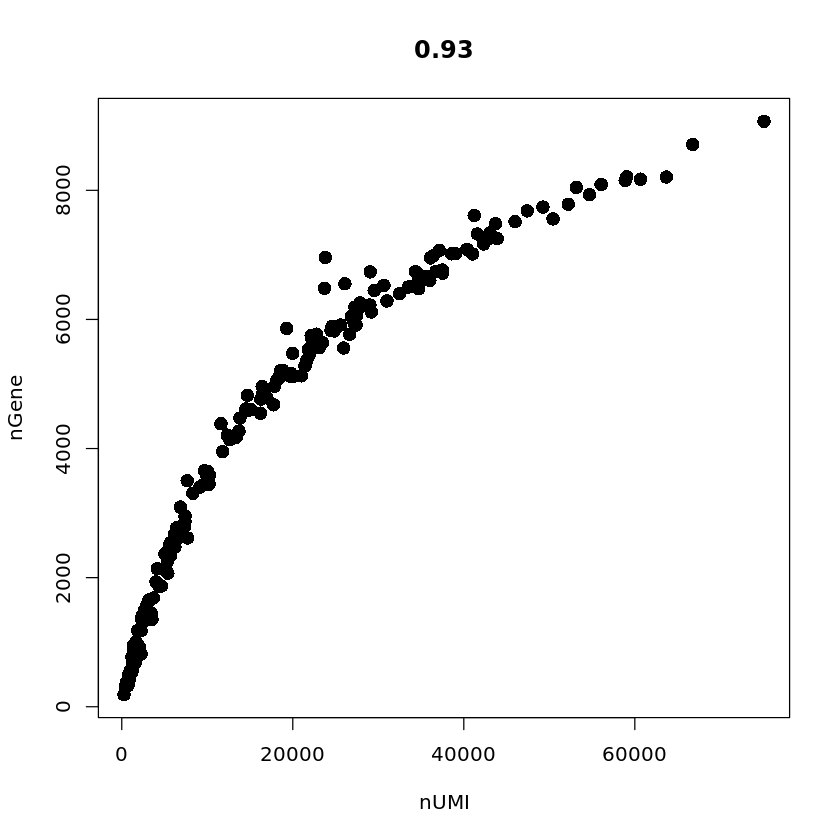

In [8]:
VlnPlot(
    object = seuset, 
    features.plot = c("nGene", "nUMI"), 
    nCol = 2
)
GenePlot(
    object = seuset, 
    gene1 = "nUMI", 
    gene2 = "nGene"
)

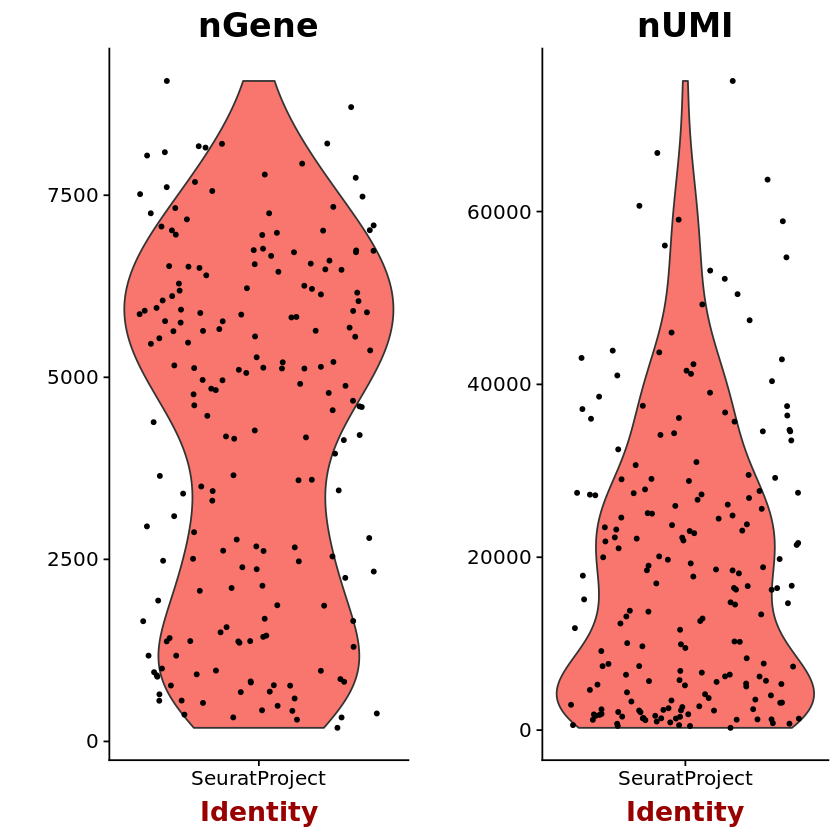

[1] 2510

The average expression and dispersion of each gene


[1] "Regressing out nUMI"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


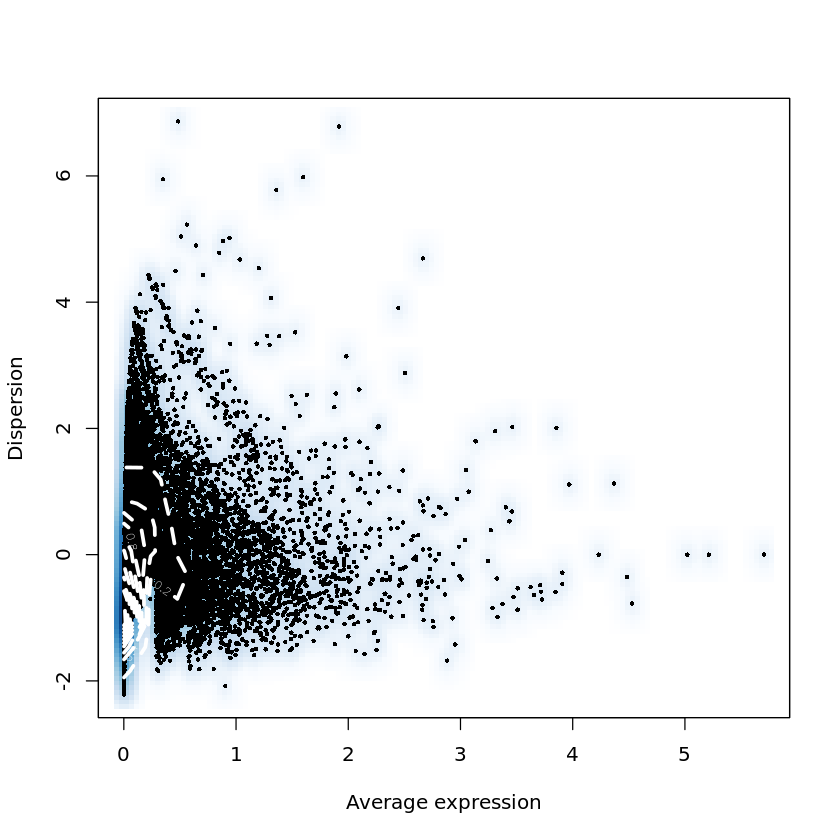

In [9]:
seuset.filter <- FilterCells(
    object = seuset,
    subset.names = c("nUMI"),
    #low.thresholds = c(5000),
    high.thresholds = c(2e7)
)

VlnPlot(
    object = seuset.filter, 
    features.plot = c("nGene", "nUMI"), 
    nCol = 2
)
    
#    subset.names = c("nUMI", "nGene"), 
#    low.thresholds = c(8000, 1),
#    high.thresholds = c(2e7, 4000)


# Great clustering, but we lose the cell groups
#    subset.names = c("nUMI", "nGene"), 
#    low.thresholds = c(8000, 4000),
#    high.thresholds = c(2e7, Inf)

# Good config:
#    subset.names = c("nUMI"), #"nGene"), 
#    low.thresholds = c(8000), #-Inf),
#    high.thresholds = c(2e7) #, Inf)
#)


# normalise
seuset.norm <- NormalizeData(
    object = seuset.filter, 
    normalization.method = "LogNormalize", 
    scale.factor = 10000
)


# HVG
seu <- FindVariableGenes(
    object = seuset.norm,
    mean.function = ExpMean, 
    dispersion.function = LogVMR, 
    x.low.cutoff = 0.0125, 
    x.high.cutoff = 3, 
    y.cutoff = 1,
    do.text = FALSE
)
length(x = seu@var.genes)
message("The average expression and dispersion of each gene")

# Confounders
seu <- ScaleData(
    object = seu, 
    vars.to.regress = c("nUMI")
    #vars.to.regress = c("nUMI", "nGene")
)

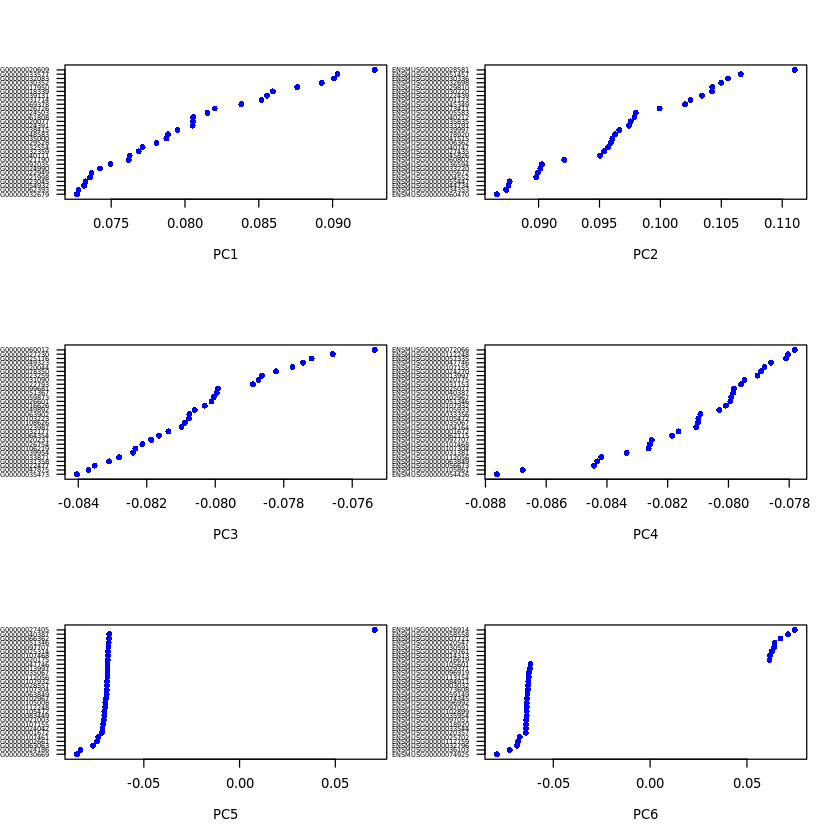

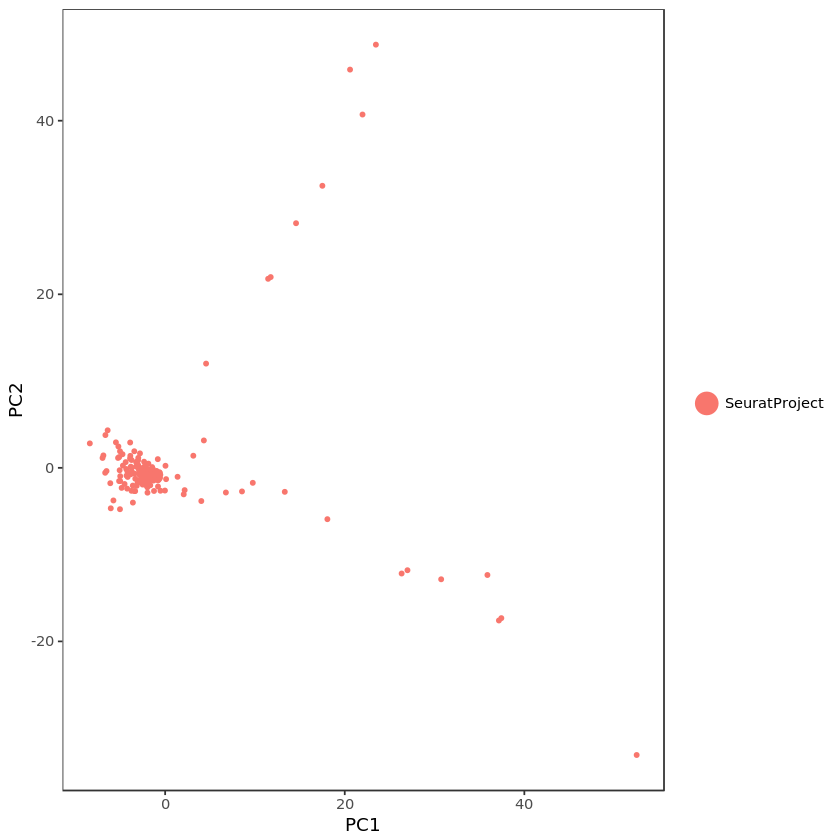

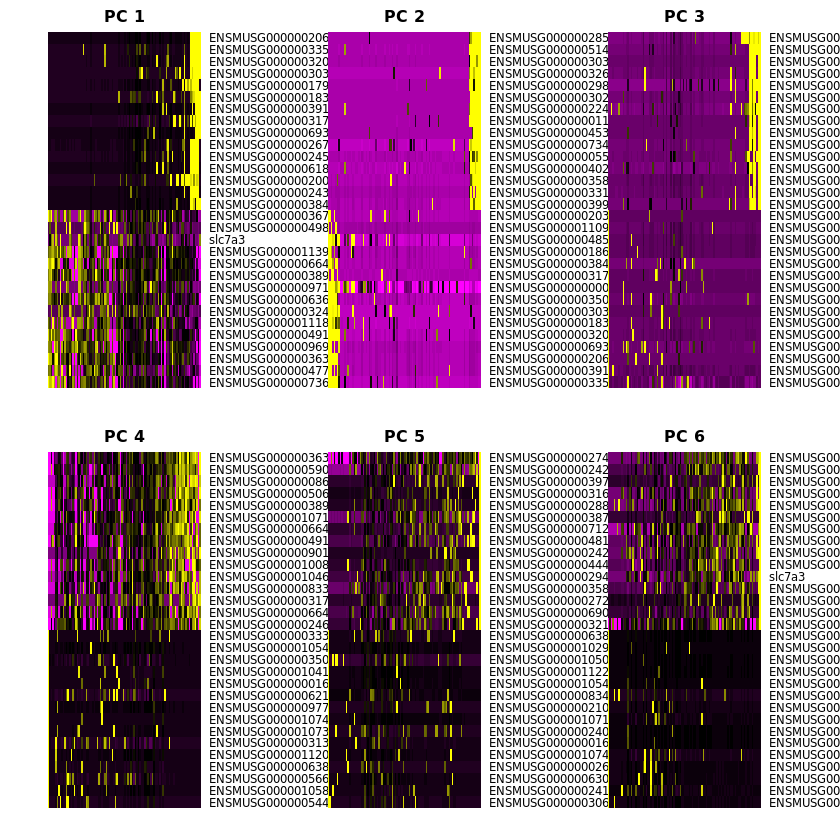

In [10]:
# Linear dim reduction
seu <- RunPCA(
    object = seu, 
    pc.genes = seu@var.genes, 
    do.print = FALSE, 
    pcs.print = 1:5, 
    genes.print = 5
)
#PrintPCA(object = seuset, pcs.print = 1:6, genes.print = 5, use.full = FALSE)

VizPCA(object = seu, pcs.use = 1:6)
PCAPlot(object = seu, dim.1 = 1, dim.2 = 2)

PCHeatmap(
    object = seu, 
    pc.use = 1:6, 
    cells.use = 100, 
    do.balanced = TRUE, 
    label.columns = FALSE,
    use.full = FALSE
)

Warning message:
“Removed 34487 rows containing missing values (geom_point).”

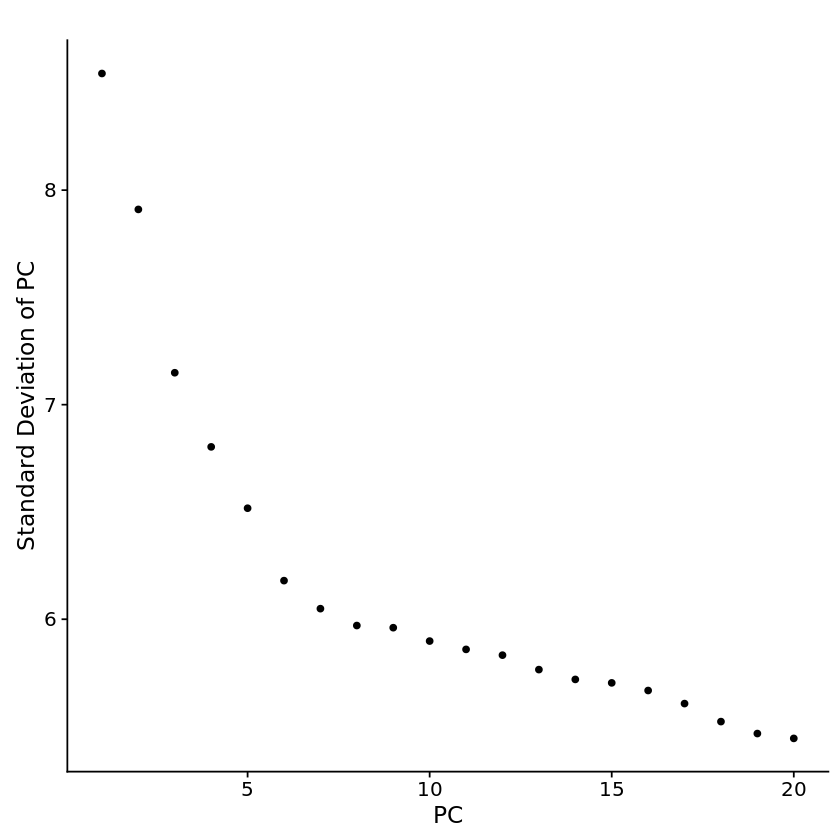

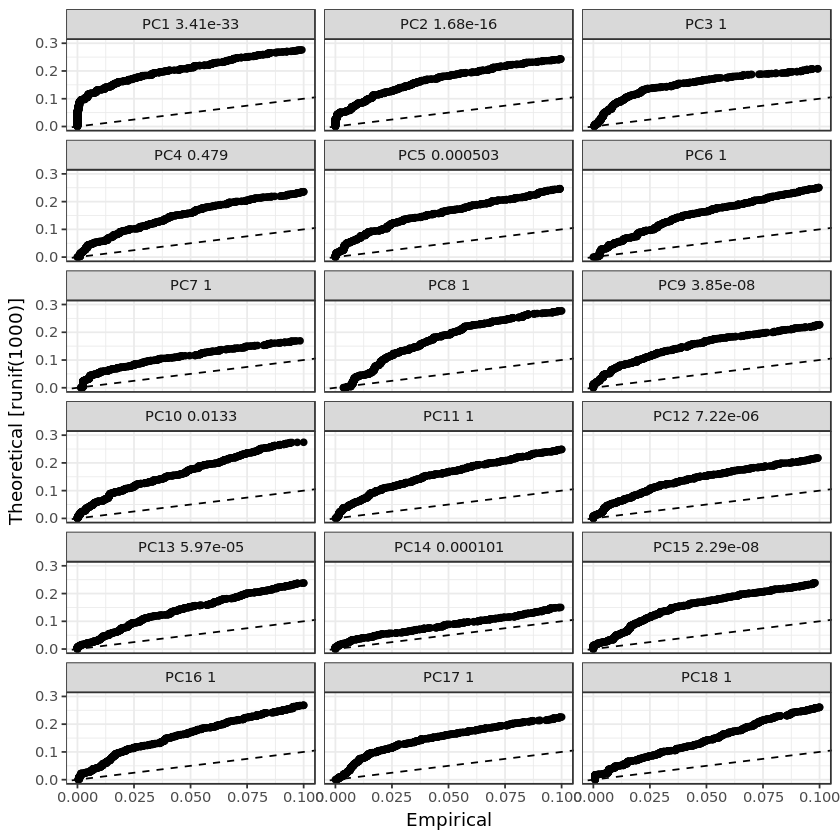

In [11]:
PCElbowPlot(object = seu)
seu <- JackStraw(
    object = seu, 
    num.replicate = 100, 
    do.print = FALSE
)
JackStrawPlot(object = seu, PCs = 1:18)

In [12]:
genes_of_interest <- c(
    "Eomes", "Brachyury", "Mesp1",                # meso
    "Pou5f1", "nanog",                            # pluripotent
    "Sox1", "Sox2", "Pou3f1", "zfp462", "slc7a3") # neuroectoderm

runPCADetector <- function(data, dims) {
    # Clustering
    clust1 <- FindClusters(
        object = data, 
        reduction.type = "pca",   # tsne, 1:2, yields 4
        dims.use = dims,            # 1:10 yields 4
        resolution = 1.0, 
        print.output = 0,
        save.SNN = TRUE,
        temp.file = "/extra/"
    )
    #PrintFindClustersParams(object = seu.clust1)
    table(clust1@ident)

    markers <- FindAllMarkers(
        object = clust1, 
        only.pos = TRUE, 
        min.pct = 0.25, 
        thresh.use = 0.25
    )

    top20 <- markers %>% group_by(cluster) %>% top_n(20, avg_logFC)

    include_genes <- unique(append(
        top20$gene, genes_of_interest
    ))

    DoHeatmap(
        object = clust1, 
        genes.use = include_genes, 
        slim.col.label = FALSE, 
        remove.key = TRUE,
        cex.row = 5,
        cex.col = 2    
    )
}

runTSNEDetector <- function(data, dims){
    clust2 <- RunTSNE(
        object = data,
        dims.use = dims,
        do.fast = TRUE,
        seed.use = 1
    )
    clust2 <- FindClusters(
        object = clust2, 
        reduction.type = "tsne",   # tsne, 1:2, yields 4
        dims.use = 1:2,            # 1:10 yields 4
        resolution = 1.0, 
        print.output = 0,
        save.SNN = TRUE,
        temp.file = "/extra/"
    )
    #PrintFindClustersParams(object = seu.clust2)
    table(clust2@ident)

    markers <- FindAllMarkers(
        object = clust2, 
        only.pos = TRUE, 
        min.pct = 0.25, 
        thresh.use = 0.25
    )

    top20 <- markers %>% group_by(cluster) %>% top_n(20, avg_logFC)

    include_genes <- unique(append(
        top20$gene, genes_of_interest
    ))

    DoHeatmap(
        object = clust2, 
        genes.use = include_genes, 
        slim.col.label = FALSE, 
        remove.key = TRUE,
        cex.row = 5,
        cex.col = 2    
    )
}

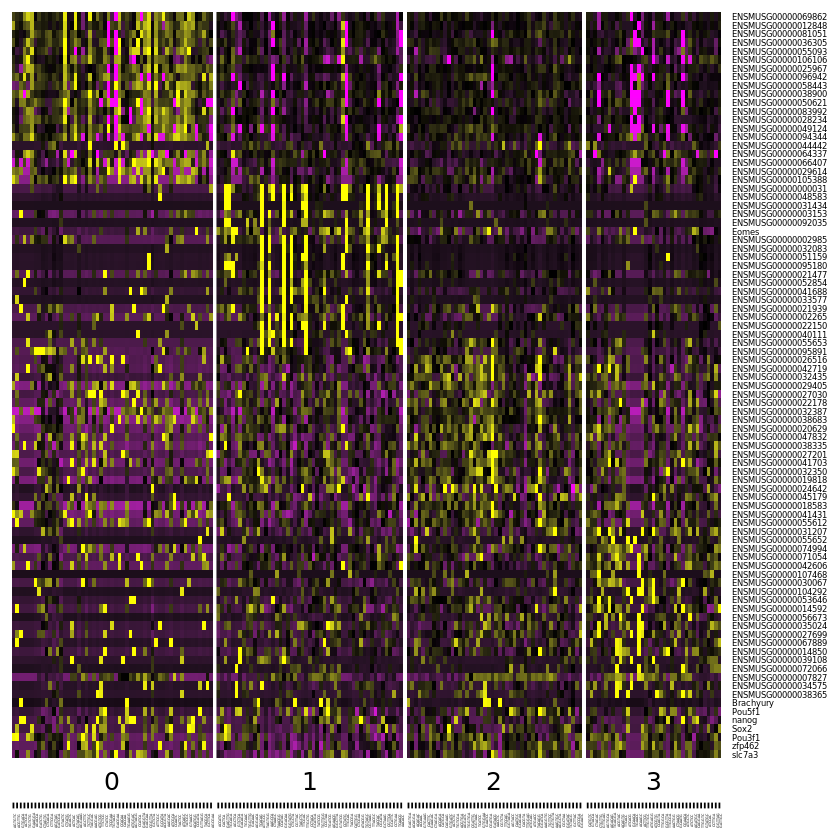

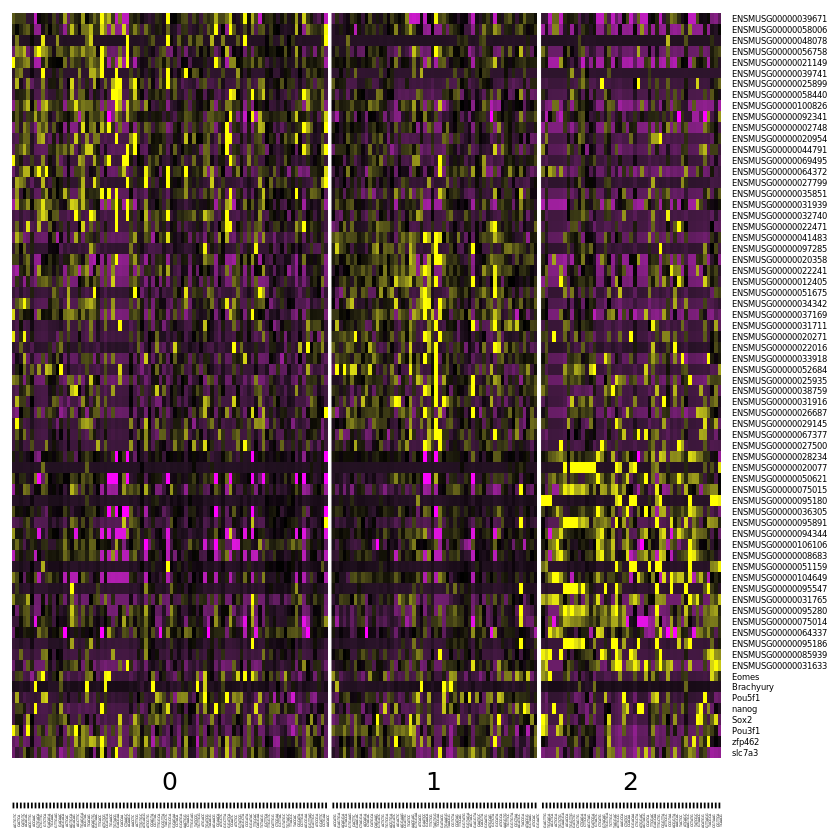

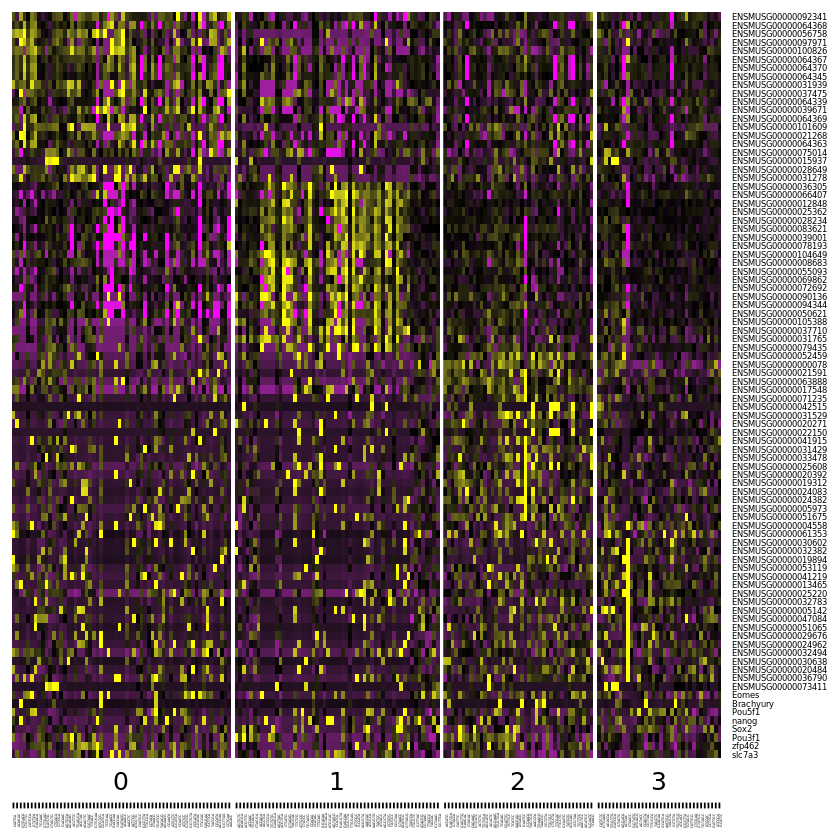

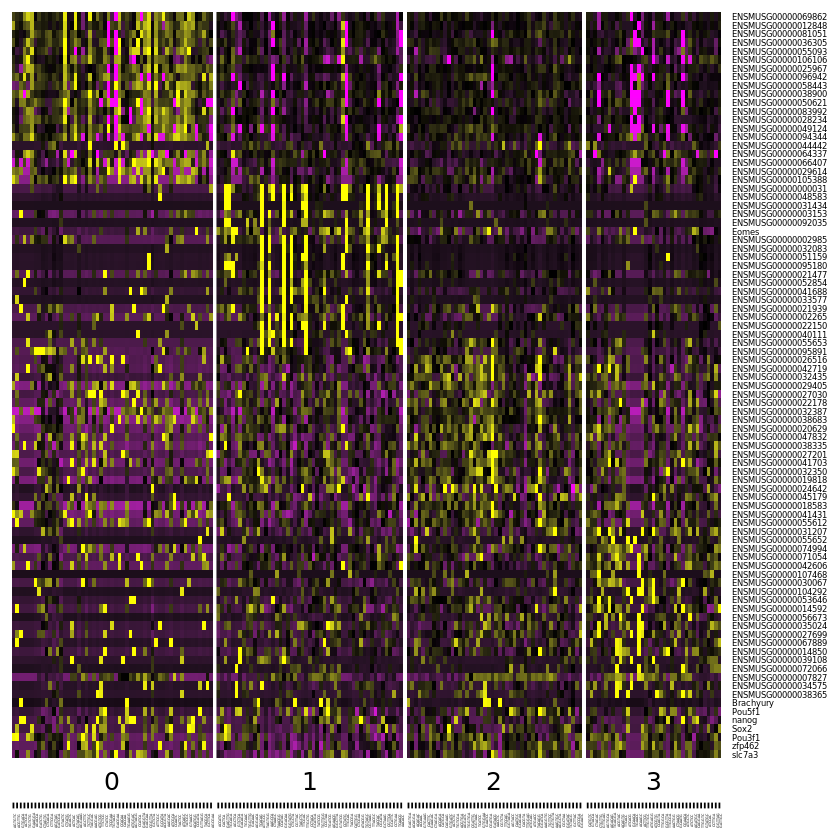

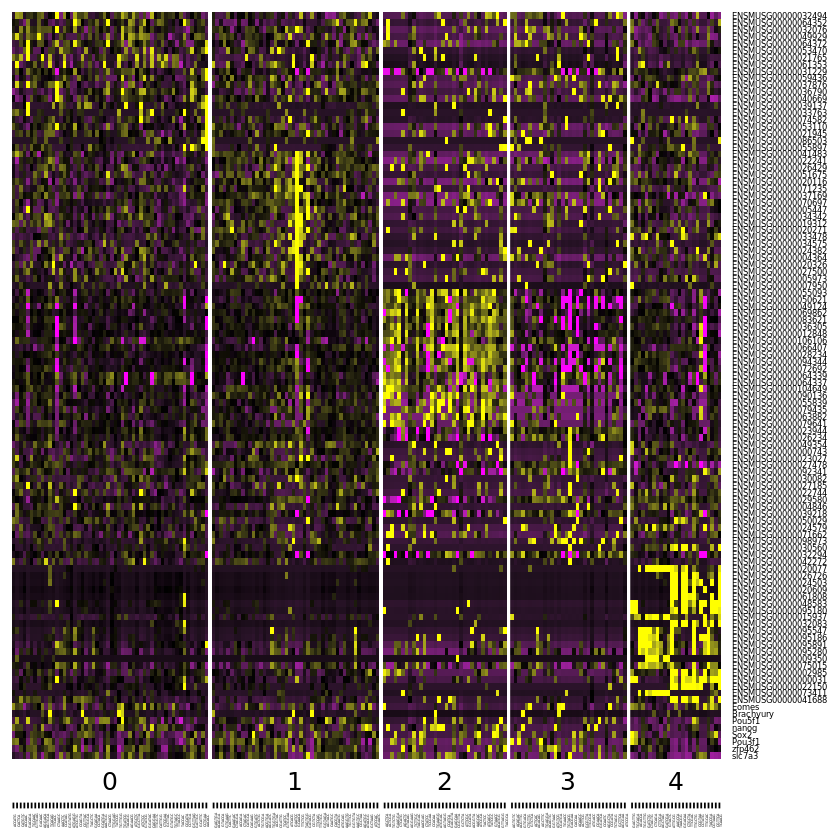

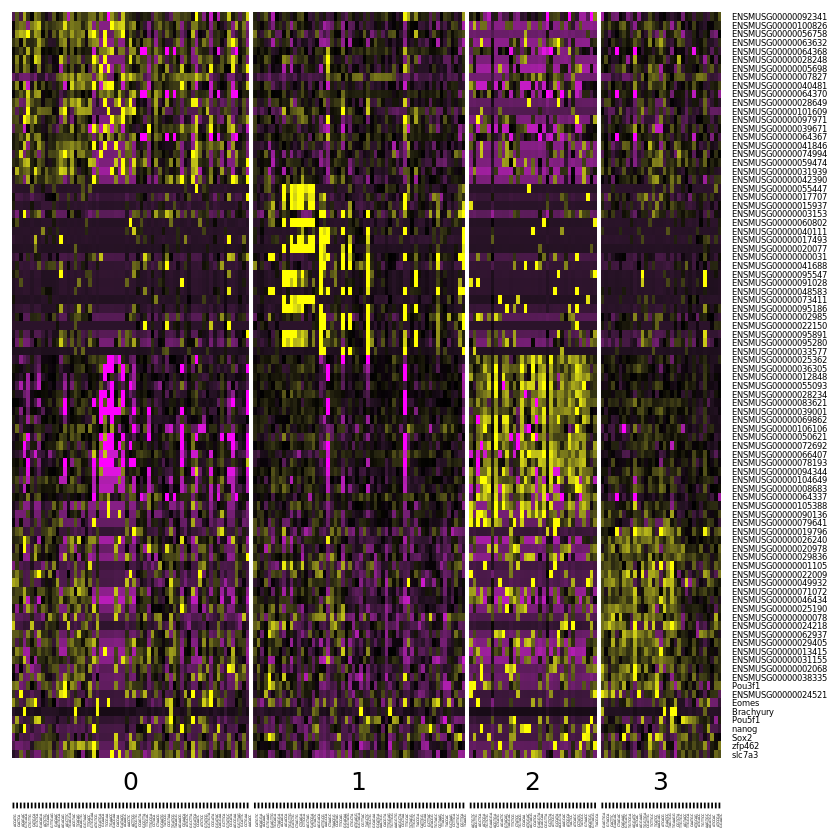

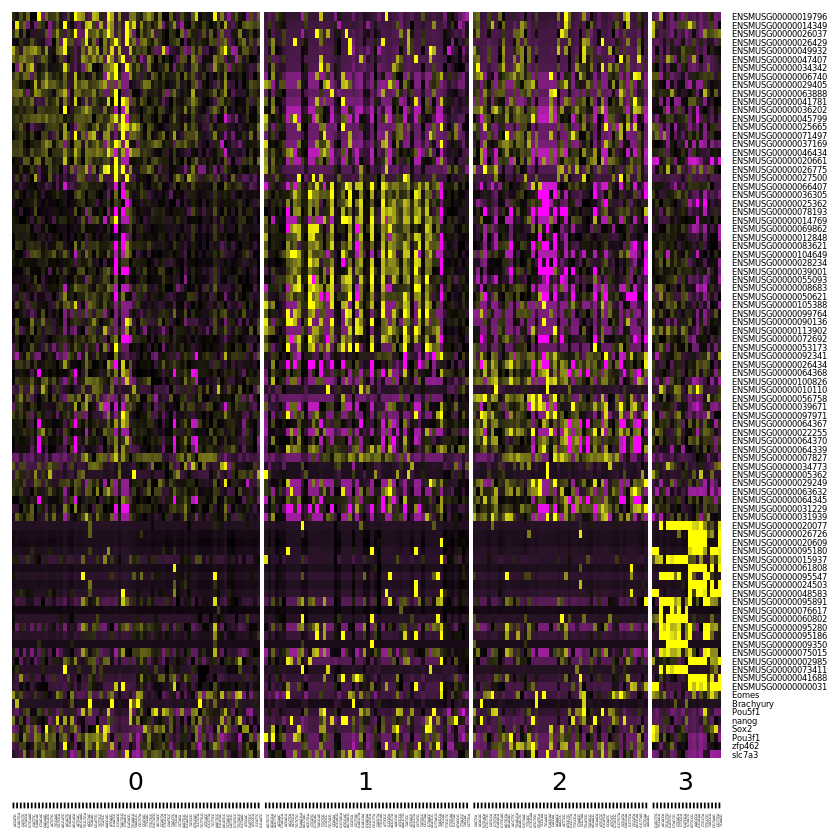

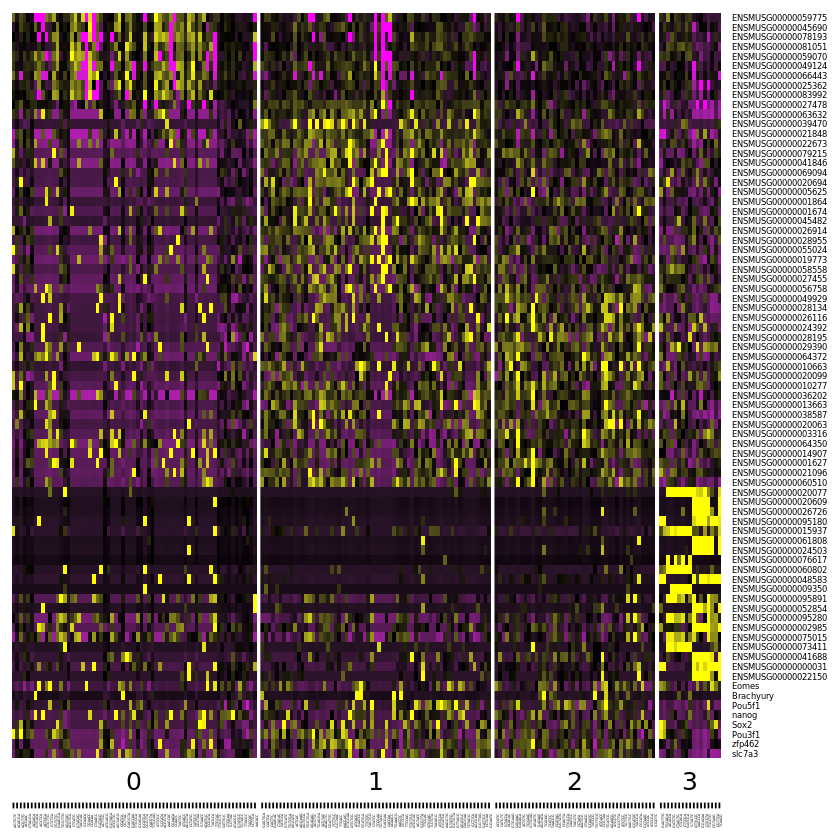

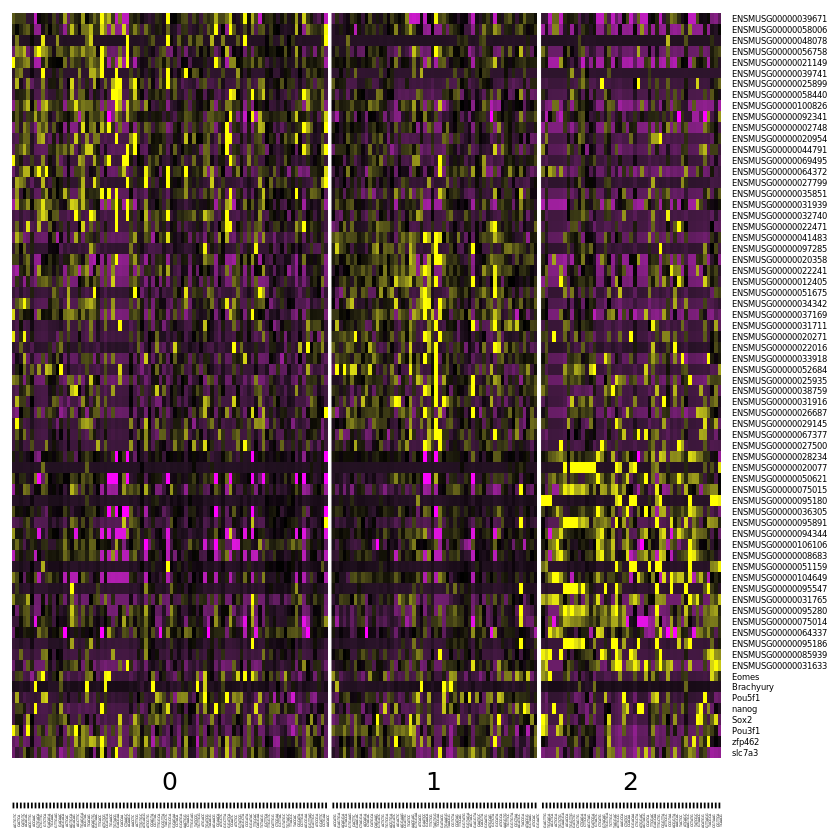

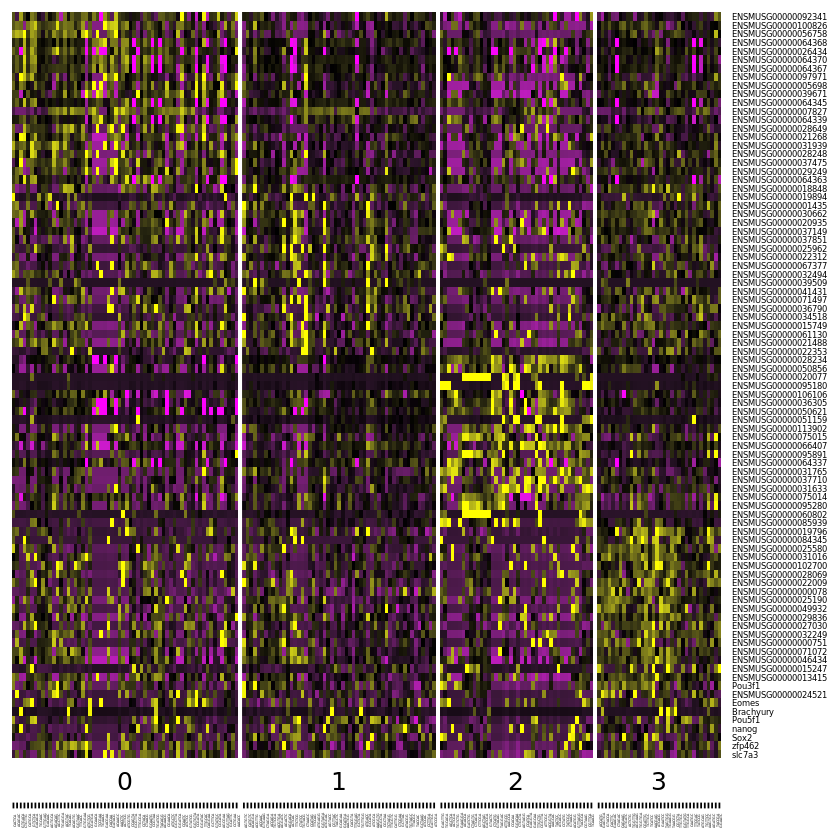

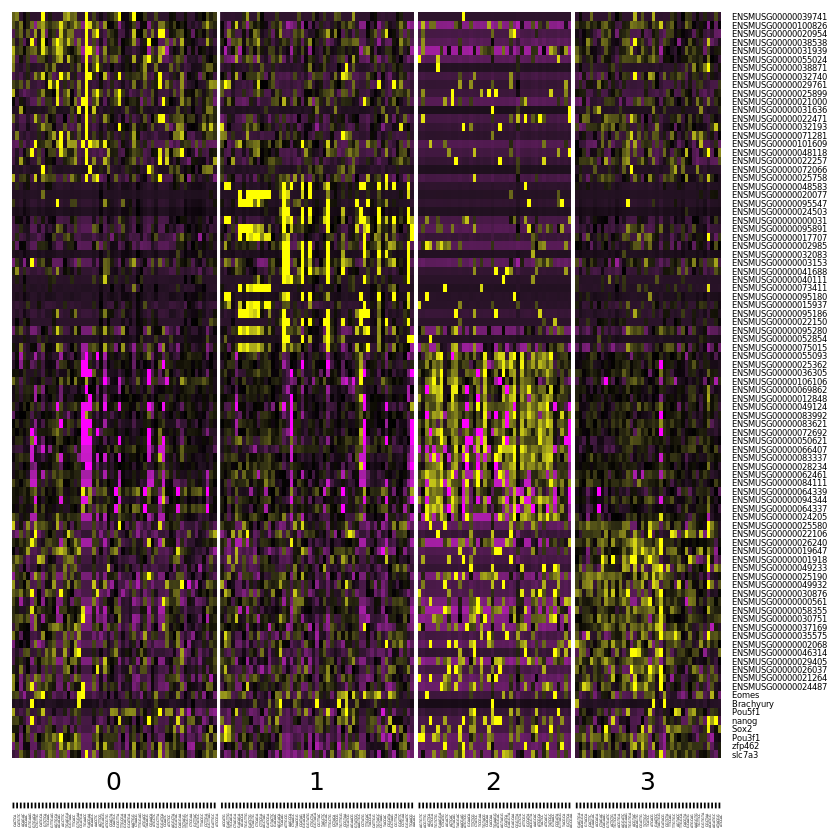

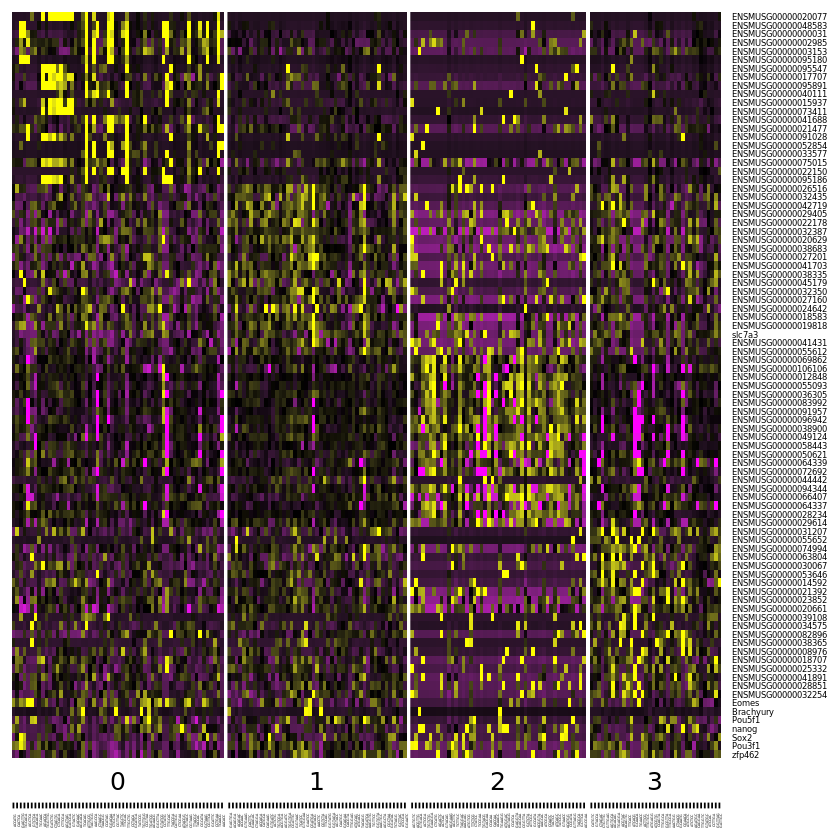

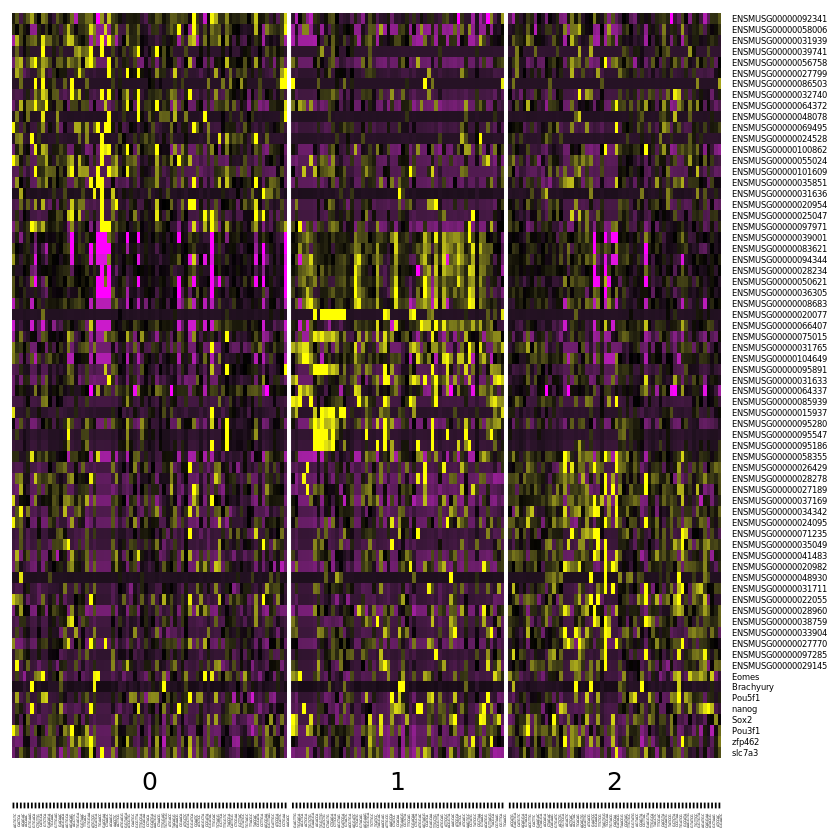

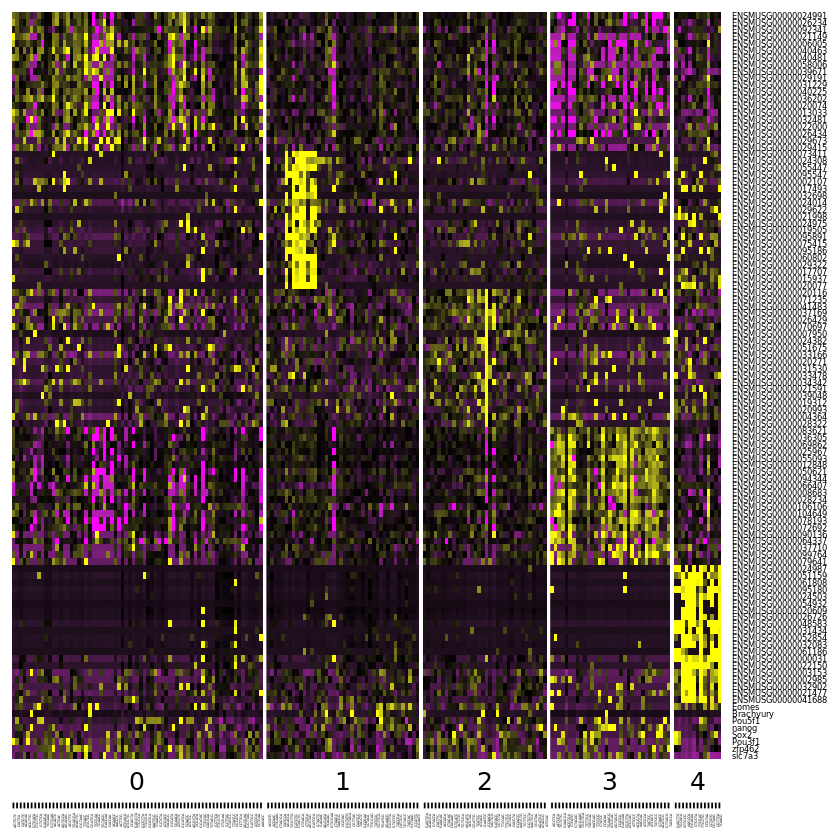

In [13]:
runPCADetector(seu, c(1,2))   
runPCADetector(seu, c(2,3))   #
runPCADetector(seu, c(3,4))
runPCADetector(seu, 1:2)
runPCADetector(seu, 1:3)
runPCADetector(seu, 1:4)
runPCADetector(seu, 1:5)
runPCADetector(seu, 1:6)
runPCADetector(seu, 2:3)       #
runPCADetector(seu, 2:4)
runPCADetector(seu, c(1,3))
runTSNEDetector(seu, c(1,2))
runTSNEDetector(seu, c(2,3))
runTSNEDetector(seu, 1:3)

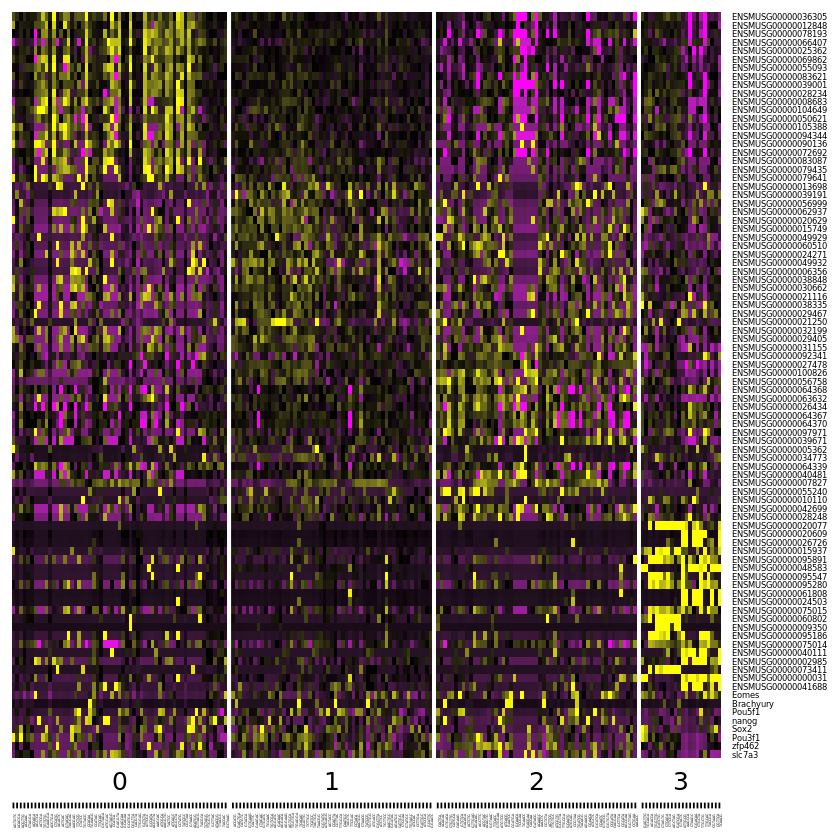

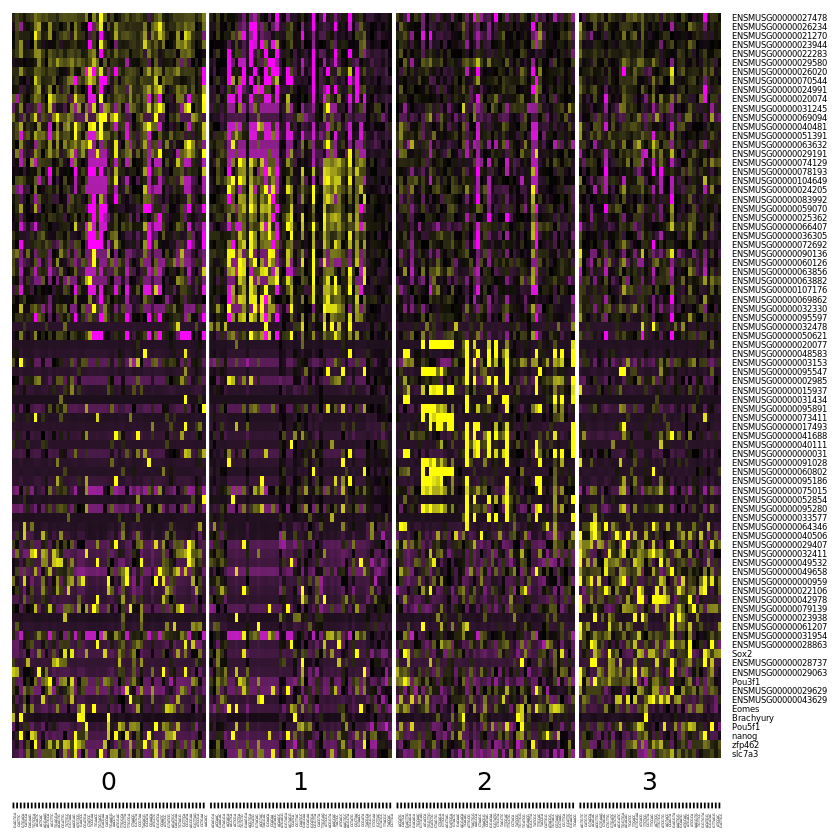

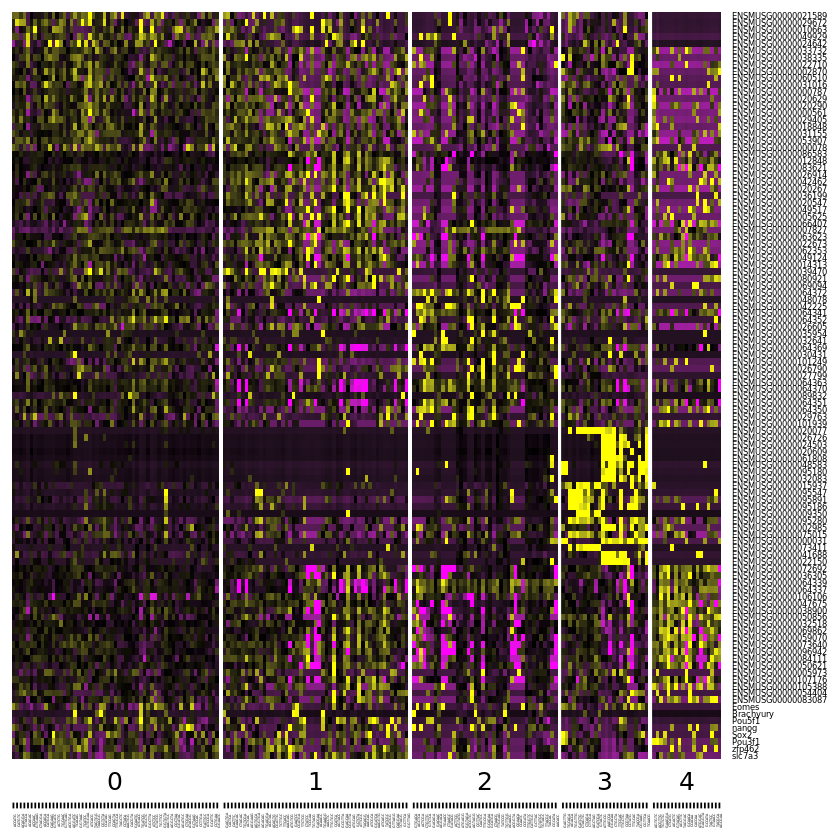

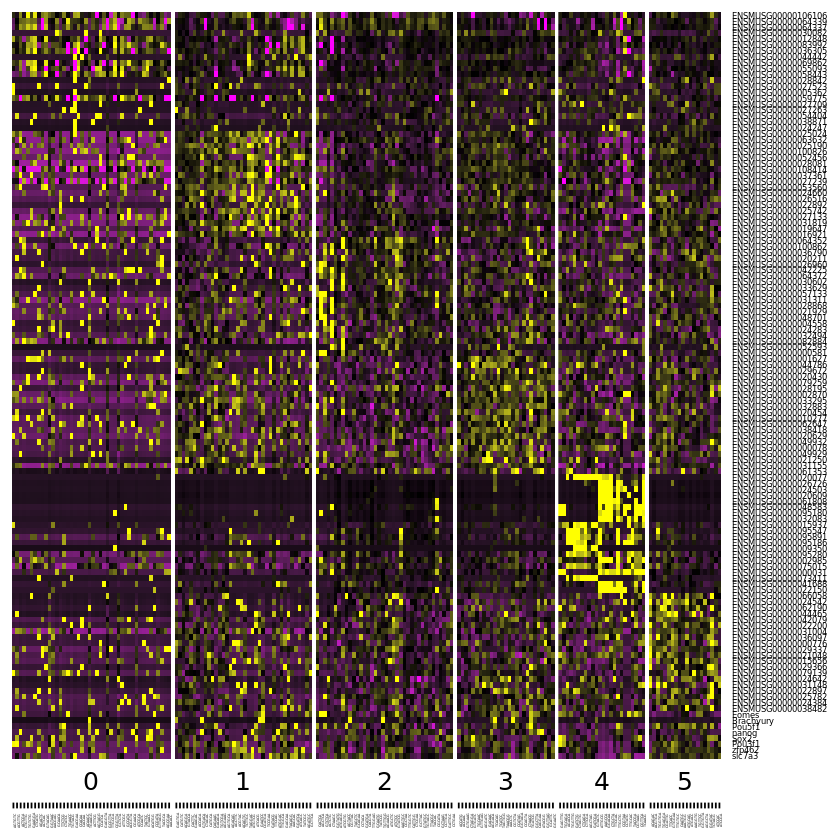

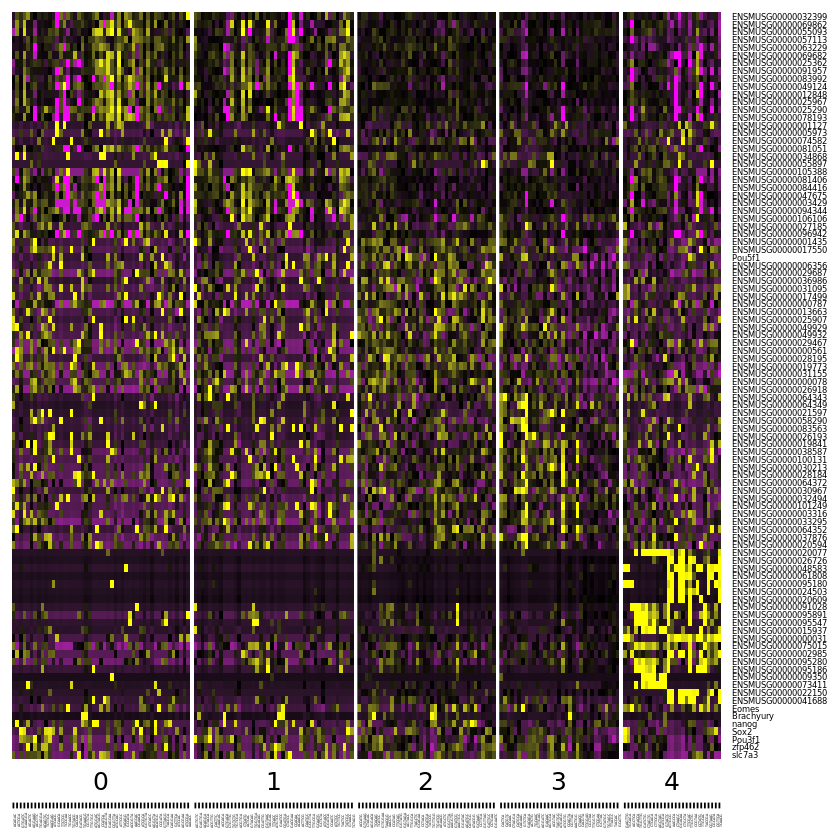

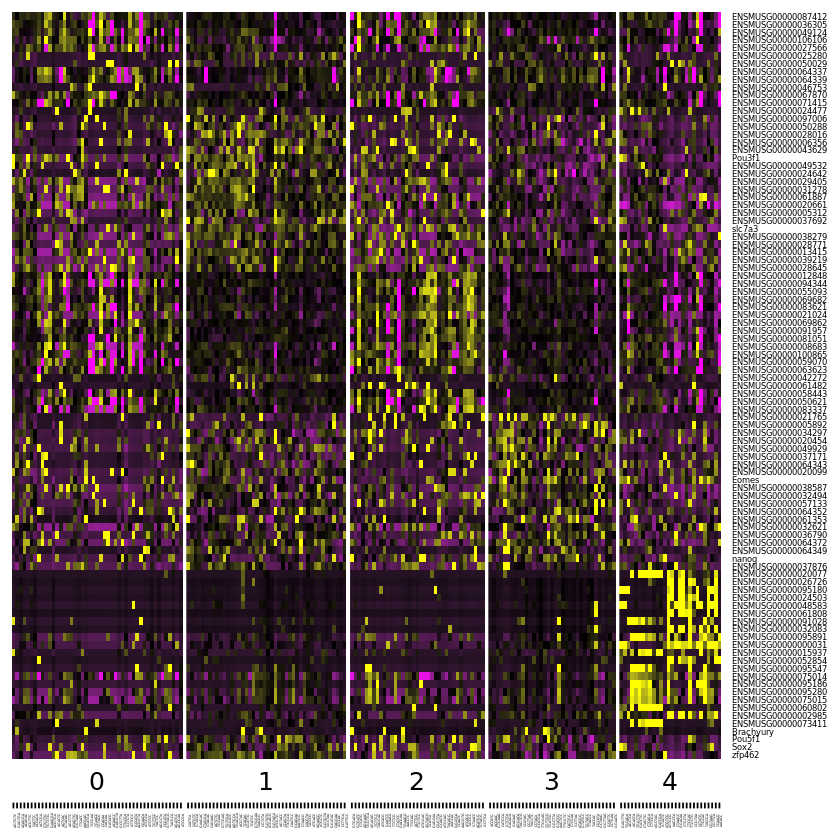

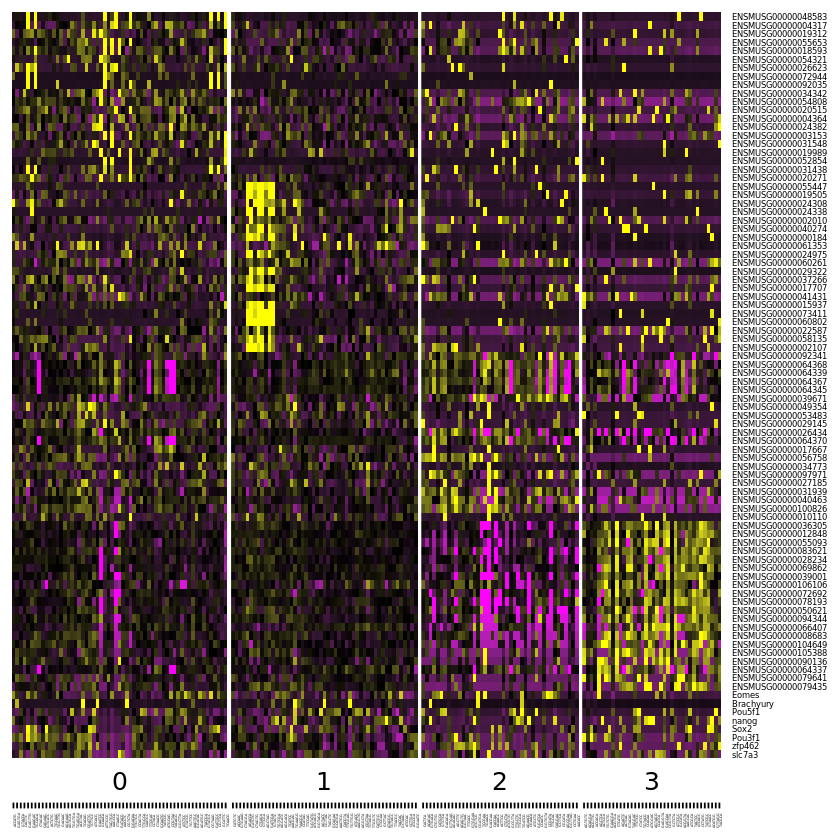

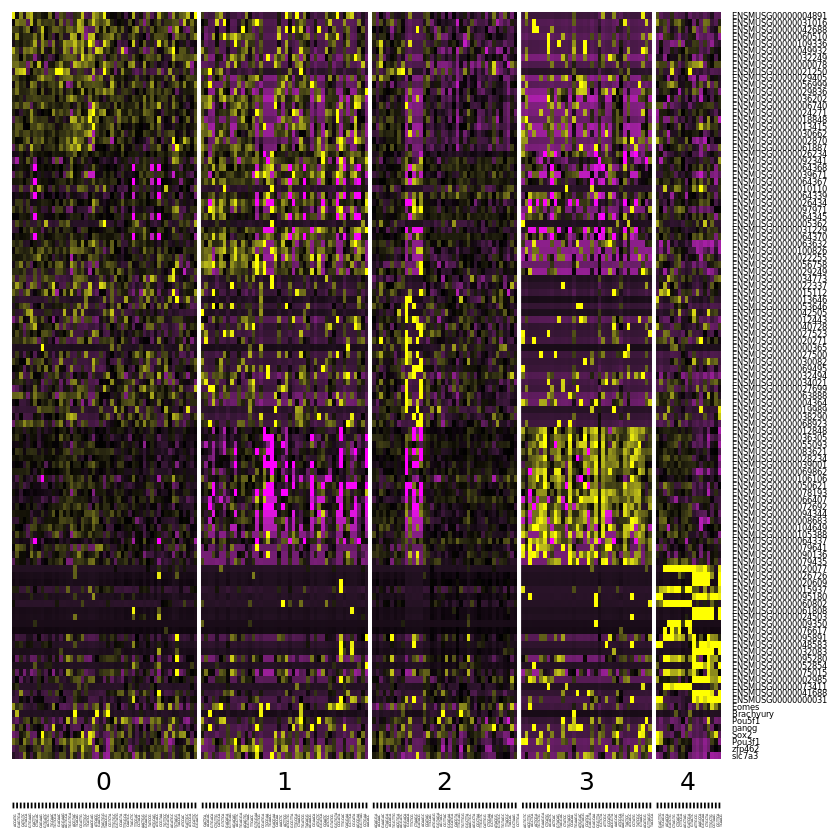

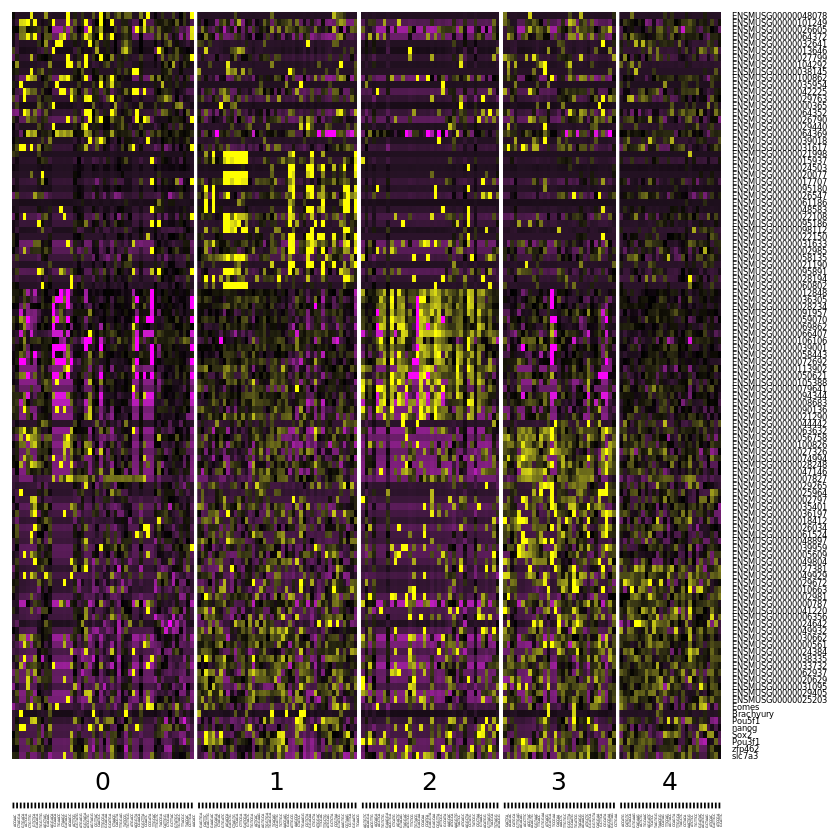

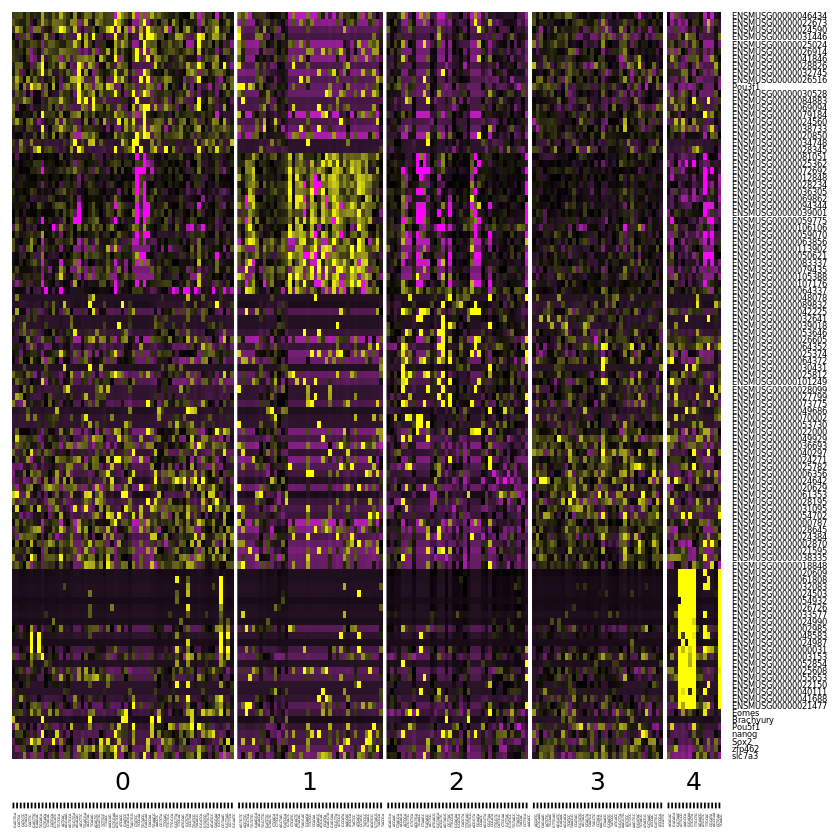

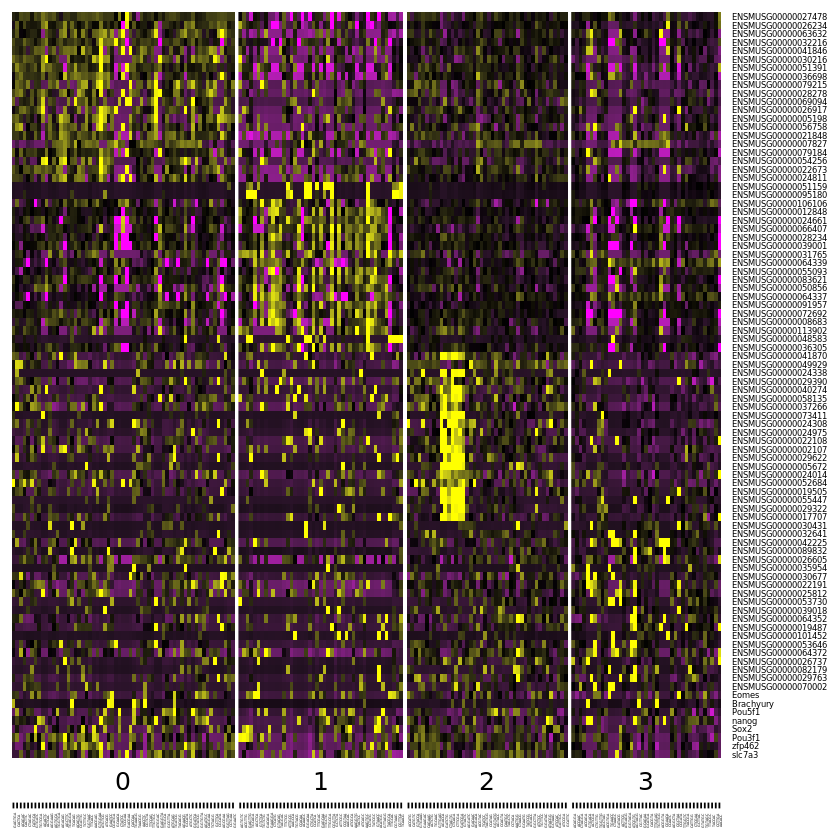

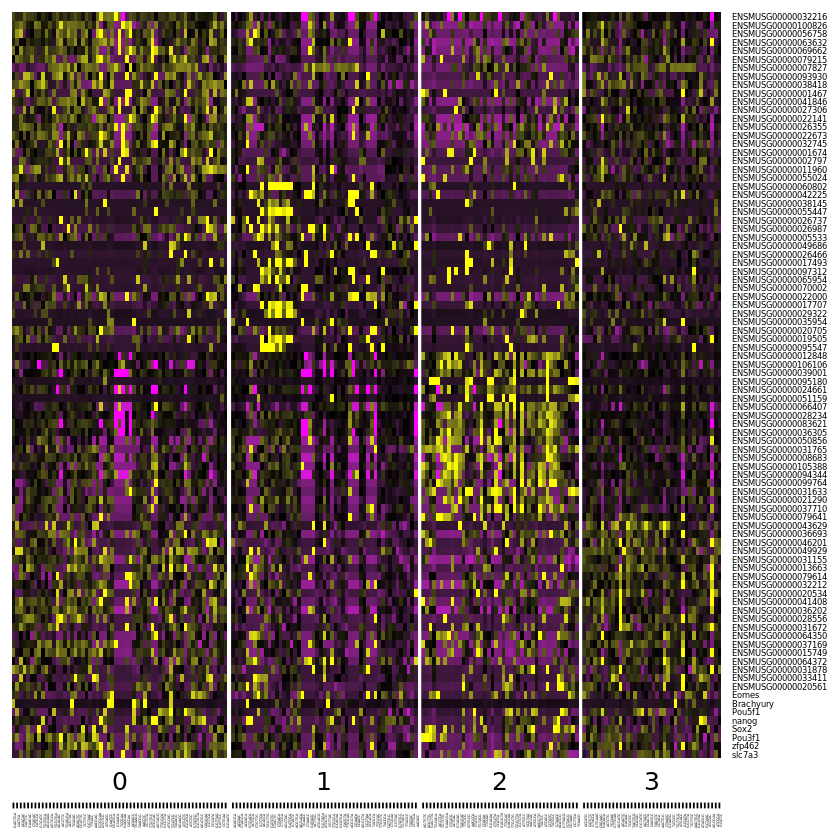

In [14]:
runTSNEDetector(seu, c(1,4))
runTSNEDetector(seu, c(1,5))
runTSNEDetector(seu, c(1,6))
runTSNEDetector(seu, c(1,7))
runTSNEDetector(seu, c(1,8))
runTSNEDetector(seu, c(1,9))
runTSNEDetector(seu, 1:4)
runTSNEDetector(seu, 1:5)
runTSNEDetector(seu, 1:6)
runTSNEDetector(seu, 1:7)
runTSNEDetector(seu, 1:8)
runTSNEDetector(seu, 1:9)

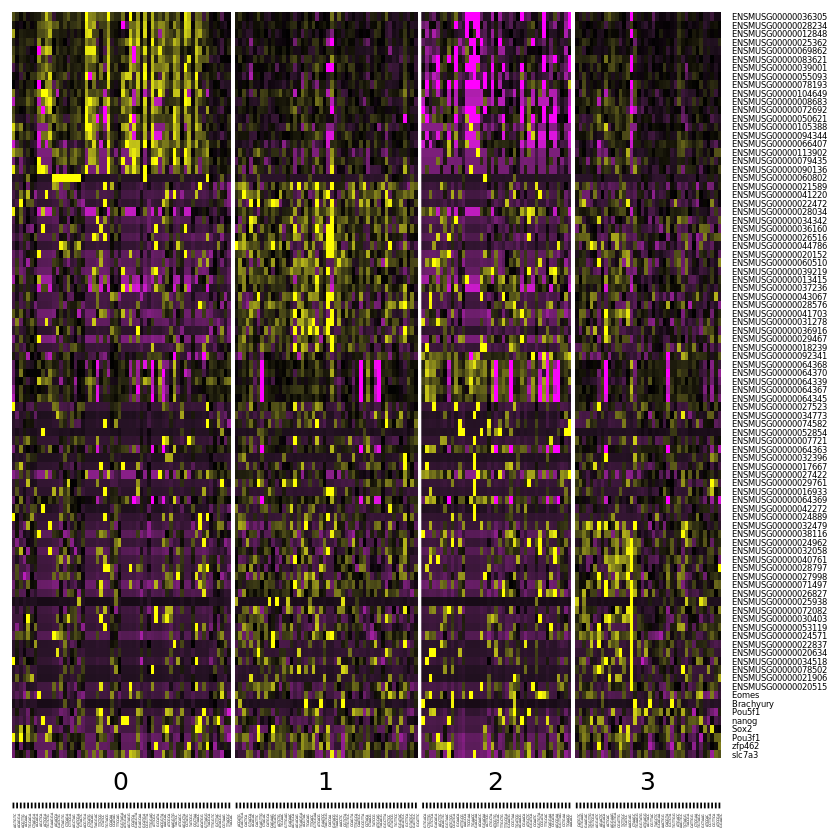

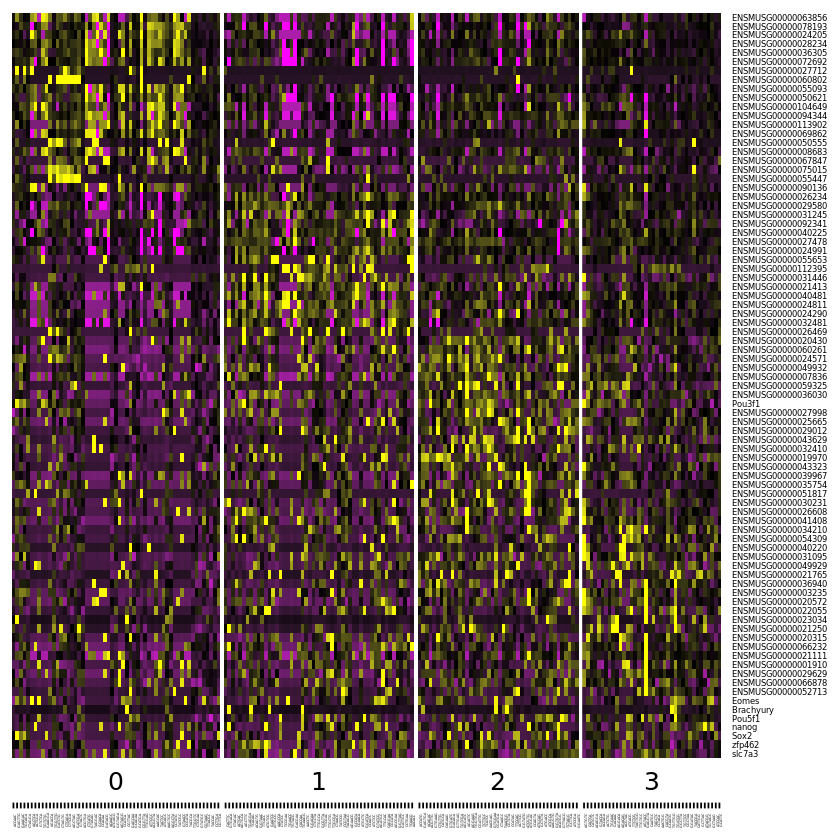

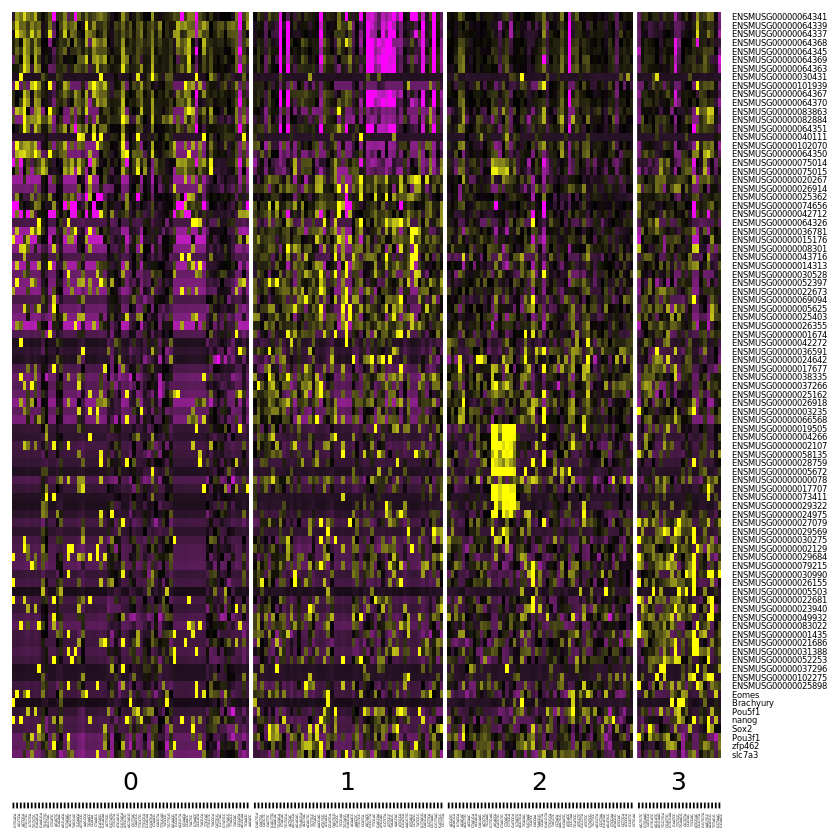

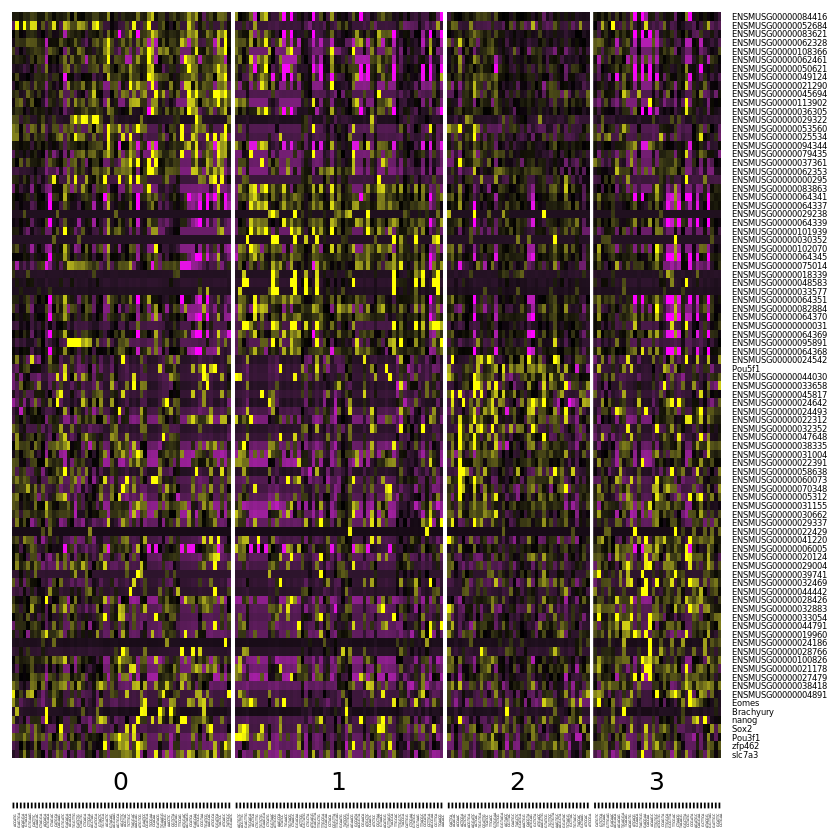

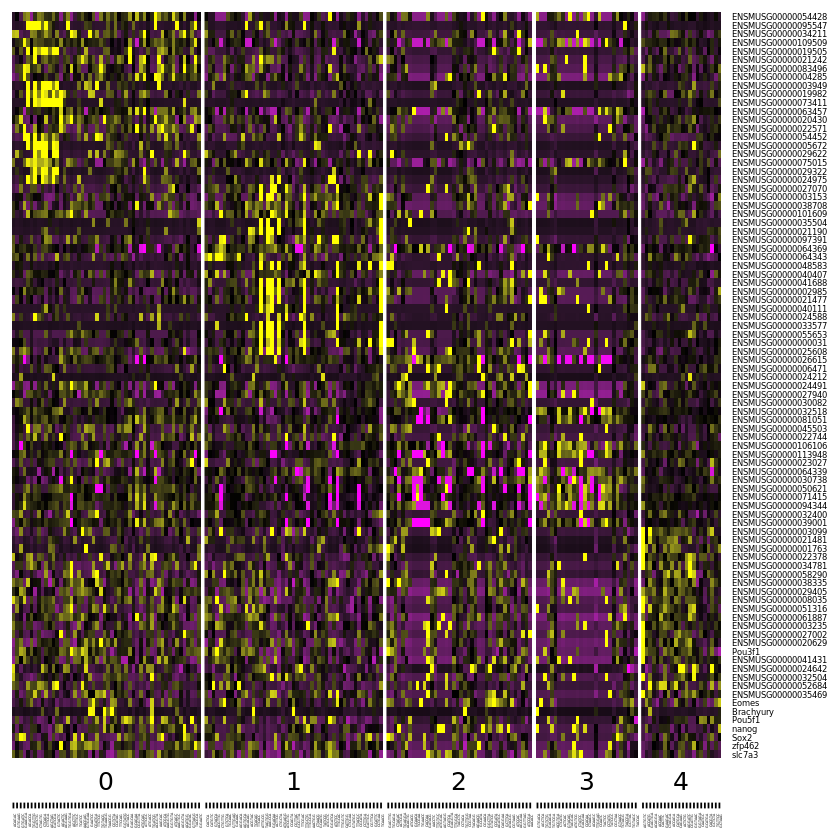

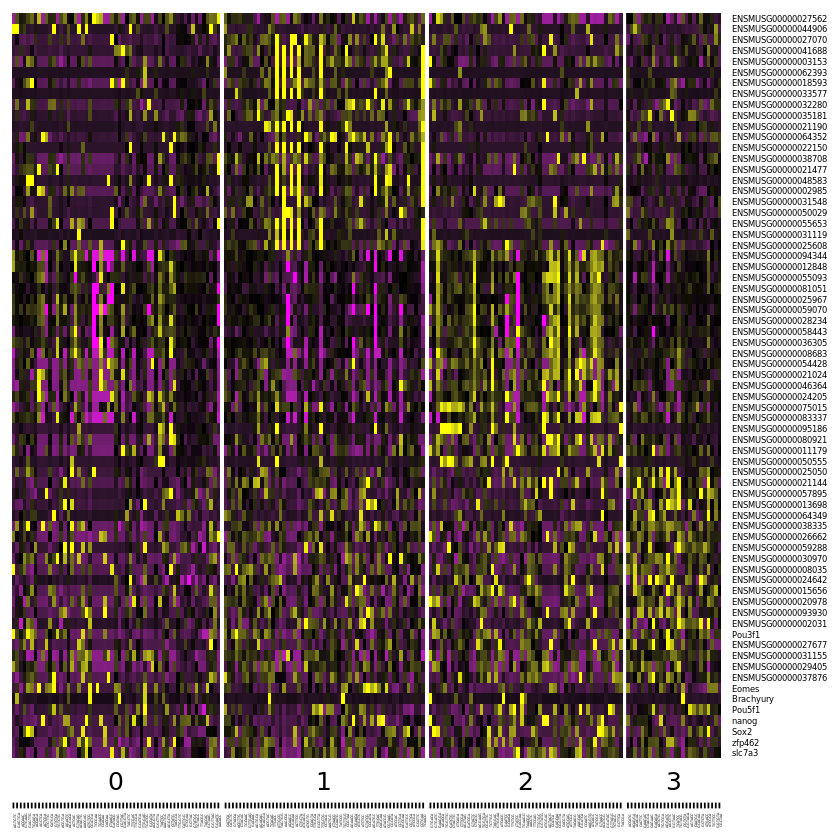

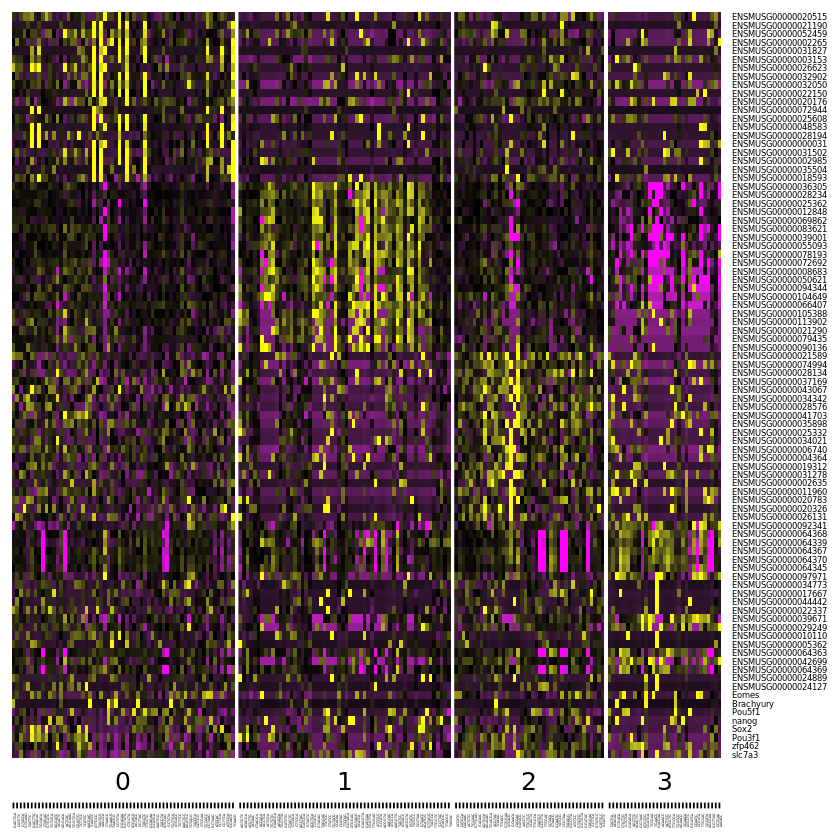

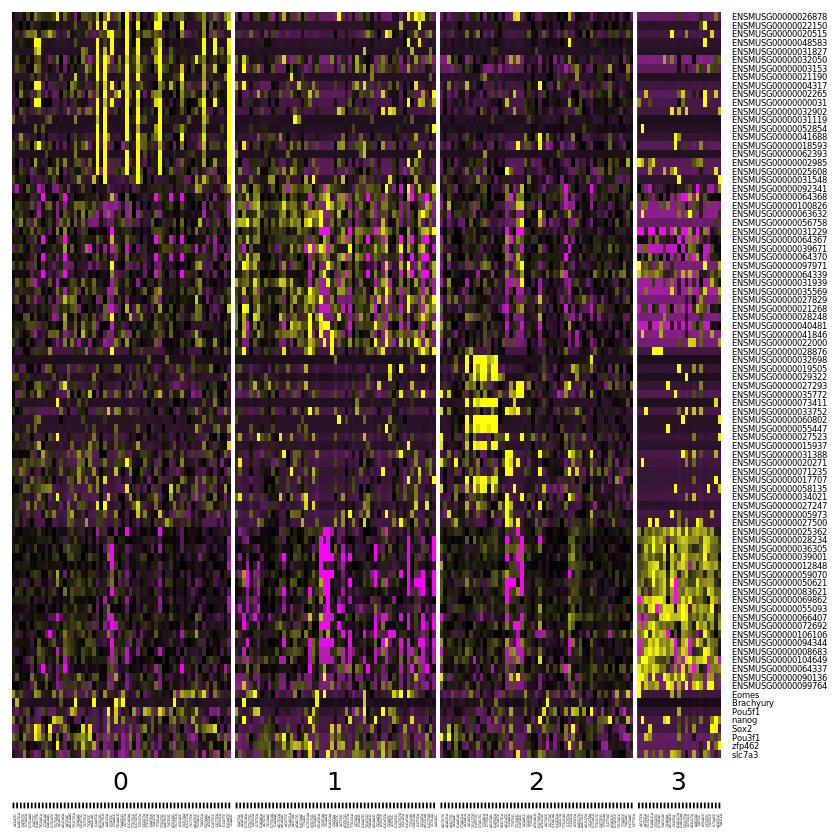

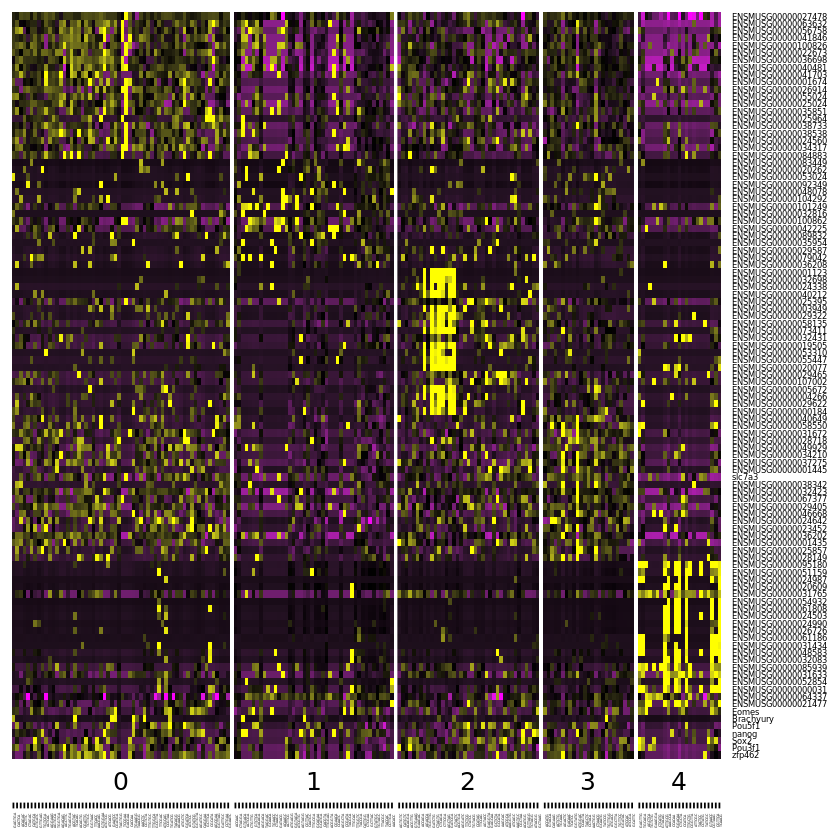

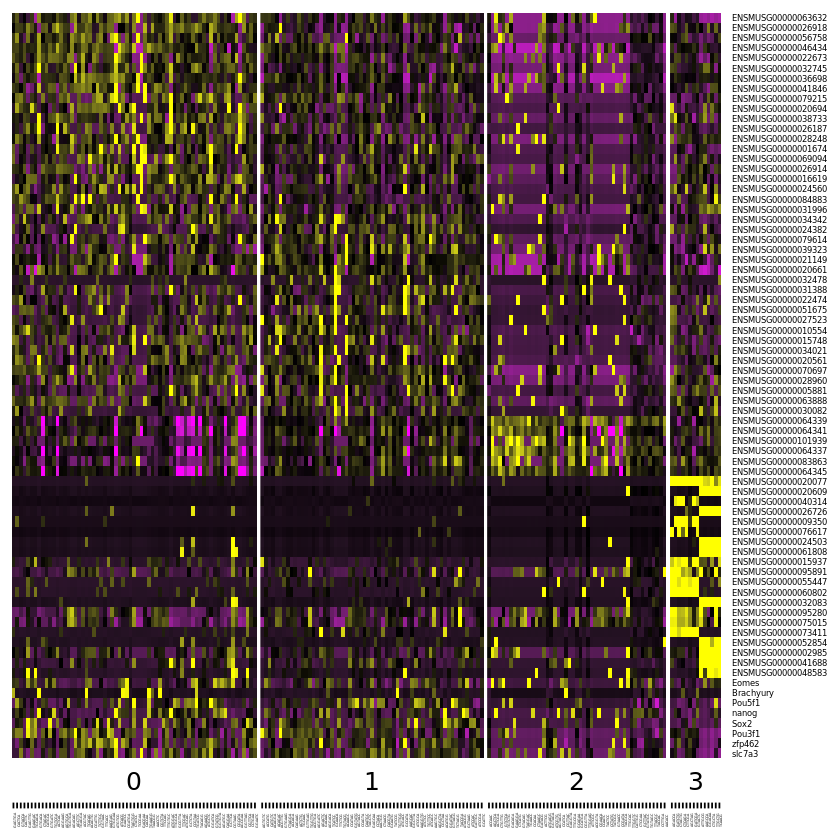

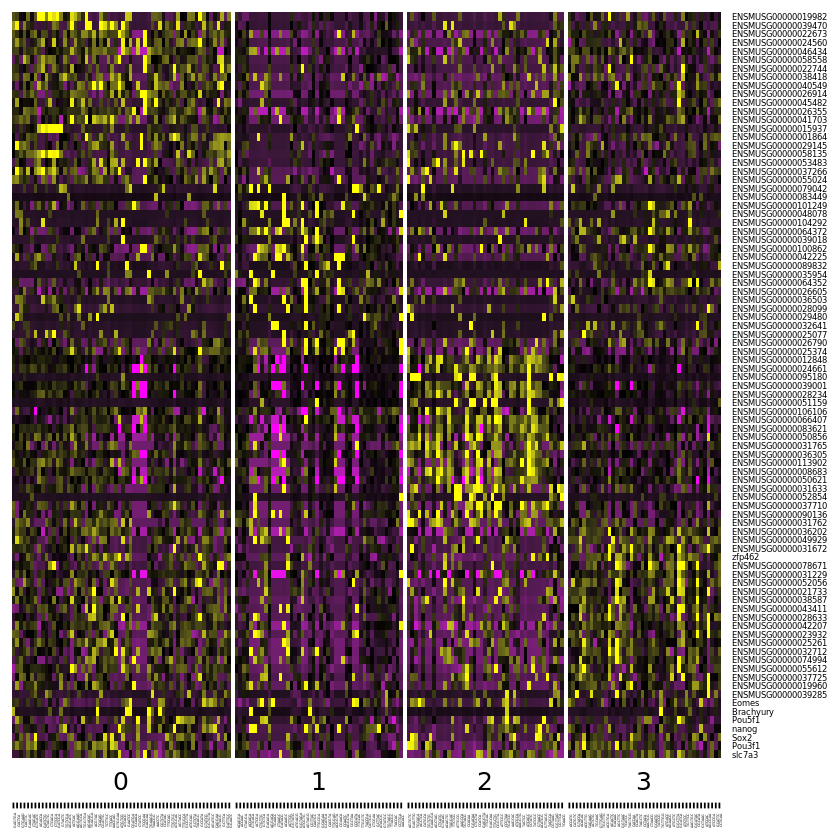

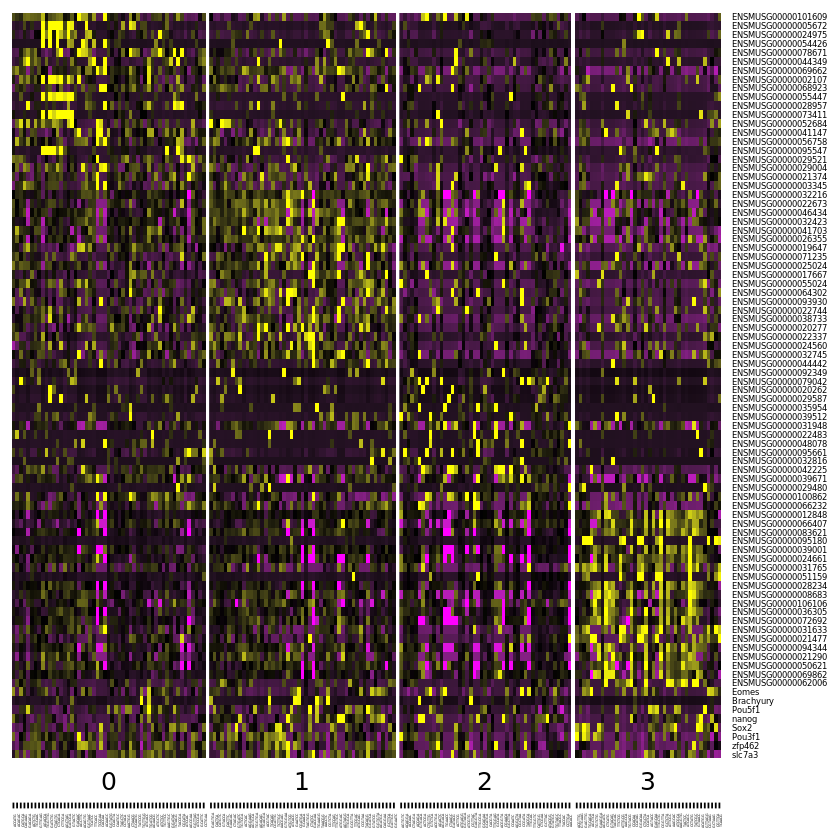

In [15]:
runTSNEDetector(seu, c(2,4))
runTSNEDetector(seu, c(2,5))
runTSNEDetector(seu, c(2,6))
runTSNEDetector(seu, c(2,7))
runTSNEDetector(seu, c(2,8))
runTSNEDetector(seu, c(2,9))
runTSNEDetector(seu, 2:4)
runTSNEDetector(seu, 2:5)
runTSNEDetector(seu, 2:6)
runTSNEDetector(seu, 2:7)
runTSNEDetector(seu, 2:8)
runTSNEDetector(seu, 2:9)

In [ ]:
for (i in 1:5){
    for (j in (i+1):6){
        PCAPlot(object = seu.clust1, dim.1 = i, dim.2 = j)
    }
}


In [ ]:
#par(mfrow = c(1, 3))
#for (i in 1:5){
#    for (j in (i+1):6){
        seu.clust1 <- RunTSNE(
            object = seu.clust1,
            dims.use = 1:5,
            do.fast = TRUE,
            seed.use = 11
        )
        TSNEPlot(object = seu.clust1)        
#    }
#}





In [ ]:
# Find Marker genes: define clusters via DE
markers2 <- FindMarkers(seu, 2)

head(markers2,6)

VlnPlot(
    object = seu, 
    features.plot = genes_of_interest, 
    size.title.use = 5,
    remove.legend = FALSE,
    single.legend = TRUE
)
message("DE for the ", 4," identified clusters")

In [ ]:
FeaturePlot(
    seu.clust1, 
    head(rownames(markers2)), 
    cols.use = c("lightgrey", "blue"), 
    nCol = 3
)